In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import glob as glob                                            # grabbing file names
import pandas as pd                                            # making dataframe for exporting parameters
import numpy as np                                             # basic math
import skimage.io as io                                        # reading in images
import os
# from skimage.measure import label, regionprops                 # image comparison tools
# from skimage.morphology import opening, disk, remove_small_objects, remove_small_holes, erosion, square    # image filtering operations
import trackpy as tp             # particle tracking toolbox
%matplotlib notebook
import matplotlib.pyplot as plt  # for plotting everything
from matplotlib import cm, colors
import seaborn as sns
# from scipy.stats import linregress
# from Tcell_CytoRubyiATP_functions import *
import matplotlib.patches as mpatches
import cv2                                                     # for filtering vector fields
from skimage.feature import peak_local_max
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
from image_plotting_tools import *
from interactive_plotting_tools import *
import czifile
import shutil
from scipy import optimize               # for curve fitting
from nm2_processivity import *

# Parameters

In [4]:
max_projection = False
frame_interval = 0.5 # in seconds

nm_per_pixel = 69.4336 # in nm
# nm_per_pixel = 48.9663 - for JL data
#filtering parameters - in pixels
filtering_kernel_size = 15
gaussian_std = 2
# peak finding parameters
min_peak_inten = 600
min_peak_distance = 5 # in pixels
# tracking parameters - all in pixels
feature_size = 11
max_feature_displacement = 7
min_track_length_frames = 5 # in frames
min_track_length_nm = 1000 # in nm
number_of_skipped_frames = 0
use_peak_image = False
smoothing_kernel = 5
# plotting colors
anterograde_color = '#d58440'
retrograde_color = '#42749d'
my_pal = {"retrograde": retrograde_color, "anterograde": anterograde_color}


# Run in batch

In [4]:
max_projection = False
frame_interval = 0.5 # in seconds

nm_per_pixel = 69.4336 # in nm
#filtering parameters - in pixels
filtering_kernel_size = 15
gaussian_std = 2
# peak finding parameters
min_peak_inten = 600
min_peak_distance = 5 # in pixels
# tracking parameters - all in pixels
feature_size = 11
max_feature_displacement = 7
min_track_length_frames = 5 # in frames
min_track_length_nm = 900 # in nm
number_of_skipped_frames = 2
use_peak_image = False
smoothing_kernel = 5
# plotting colors
anterograde_color = '#d58440'
retrograde_color = '#42749d'


condition_list = ['2A_Halo', '2B_Halo']

for condition in condition_list:
    folder_list = sorted(glob.glob(condition + '/*Airyscan Processing'))
    
    for folder in folder_list:
        filename = glob.glob(folder + '/*.czi')
        if len(filename) == 0:
            filename = glob.glob(folder + '/*Processing.tif')
        filename = filename[0]
        
        # read in the image stack
        if filename[-3:] == 'tif':
            imstack = io.imread(filename)
        elif filename[-3:] == 'czi':
            imstack = czifile.czifile.imread(filename)
            imstack = np.squeeze(imstack)

        # check to see if you need to make a max projection
        if max_projection:
            imstack = np.max(imstack, axis = 1)
        
        # filter the image
        imstack_LoG = filter_image(imstack, filename, filtering_kernel_size+2, gaussian_std)
        
        # find the peaks
        all_myosin = tp.batch(imstack_LoG[:], feature_size, minmass=min_peak_inten, separation = 3)

        # check whether subpixel accuracy is decent. Should be relatively flat distribution
        tp.subpx_bias(all_myosin)
        
        # link tracks
        myosin_tracks = tp.link_df(all_myosin, search_range=max_feature_displacement, adaptive_stop = 5, memory=number_of_skipped_frames)
        # filter based on minimum length
        myosin_tracks_filtered = tp.filter_stubs(myosin_tracks, min_track_length_frames)
        
        # smooth the tracks and calculate track parameters      
        myosin_trackdata_df = calculate_trajectory_parameters2(myosin_tracks_filtered, filename, imstack[0], frame_duration=frame_interval,
                                nm_per_pixel=nm_per_pixel, smoothing_window_size=smoothing_kernel)
        
        # make plots of trajectories
        plot_valid_tracks_overlay(myosin_trackdata_df, imstack[0], filename)
        plot_trajectories_w_histogram(myosin_trackdata_df, filename)
#         plot_centered_trajectories(myosin_trackdata_df, filename, smooth_trajectories=True, save_image=True)

        # make tracked movie
#         make_tracked_movie_stack(filename, imstack, myosin_tracks_filtered, anterograde_myosin_particles, retrograde_myosin_particles, min_inten = 35, max_inten = 4800)
        
        

Frame 231: 51 trajectories present.


# Lumping 2A and 2B together for Analysis

In [93]:
all_data = pd.DataFrame()

condition_list = ['2A_Halo','2B_Halo']
for condition in condition_list:
    folder_list = sorted(glob.glob(condition + '/*Airyscan*'))
    for folder in folder_list:
        data_file = folder + folder[folder.rfind('/'):] + '_filtered_trackdata.h5'
        myosin_tracks = pd.read_hdf(data_file)
        myosin_tracks['folder'] = [data_file[:data_file.find('/')]] * len(myosin_tracks)
        myosin_tracks['file'] = [data_file[data_file.rfind('/') + 1 :data_file.rfind('Airyscan')]] * len(myosin_tracks)
        # myosin_tracks.head()
        all_data = pd.concat([all_data, myosin_tracks])
        
corrected_actual_velocity_smoothed = []
for i, row in all_data.iterrows():
    if row['flow'] == 'retrograde':
        corrected_actual_velocity_smoothed.append(row['average_velocity'] * -1)
    elif row['flow'] == 'anterograde':
        corrected_actual_velocity_smoothed.append(row['average_velocity'])
    else:
        corrected_actual_velocity_smoothed.append(0)

all_data['signed_average_velocity'] = corrected_actual_velocity_smoothed
all_data = all_data.reset_index(drop=True)

# only keep the retrograde or anterograde tracks
all_data = all_data[(all_data['flow'] == 'retrograde') | (all_data['flow'] == 'anterograde')]

all_data.to_hdf('myosin_2A_and_2B_all_data_combined.h5', key='myosin', mode='w')

In [13]:
# read in the file
all_data = pd.read_hdf('myosin_2A_and_2B_all_data_combined.h5', key='myosin')

all_2a = all_data[all_data['folder'] == '2A_Halo']
all_2b = all_data[all_data['folder'] == '2B_Halo']

retro2a = all_2a[all_2a['flow'] == 'retrograde']
antero2a = all_2a[all_2a['flow'] == 'anterograde']

retro2a_fit, retro2a_bins, retro2a_params, retro2a_rsquared = gaussian_fit_line(retro2a['signed_average_velocity'], flow_direction = 'retrograde')
antero2a_fit, antero2a_bins, antero2a_params, antero2a_rsquared = gaussian_fit_line(antero2a['signed_average_velocity'], flow_direction='anterograde')

retro2b = all_2b[all_2b['flow'] == 'retrograde']
antero2b = all_2b[all_2b['flow'] == 'anterograde']

retro2b_fit, retro2b_bins, retro2b_params, retro2b_rsquared = gaussian_fit_line(retro2b['signed_average_velocity'], flow_direction = 'retrograde')
antero2b_fit, antero2b_bins, antero2b_params, antero2b_rsquared = gaussian_fit_line(antero2b['signed_average_velocity'], flow_direction='anterograde')

<IPython.core.display.Javascript object>


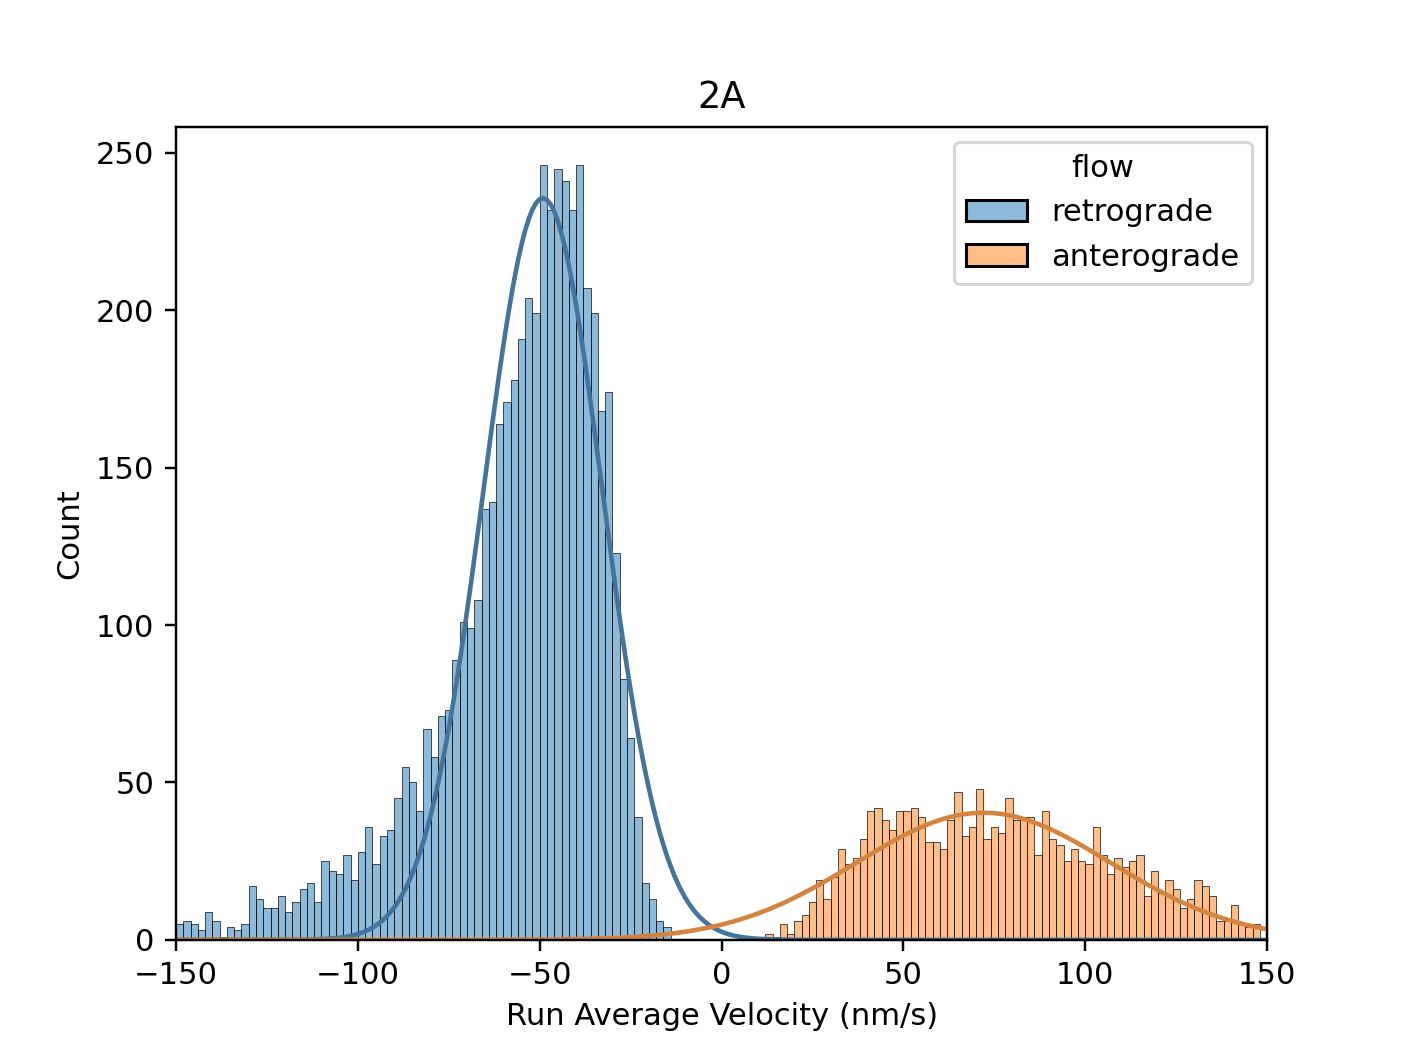

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Retrograde:  -49.127409198468094  +/-  16.33888332818534 in  5296  events   -   R^2 =  0.9306873891327927
Anterograde:  71.987850790573  +/-  34.95383875395916 in  1826  events   -   R^2 =  0.8128975791761066


<IPython.core.display.Javascript object>


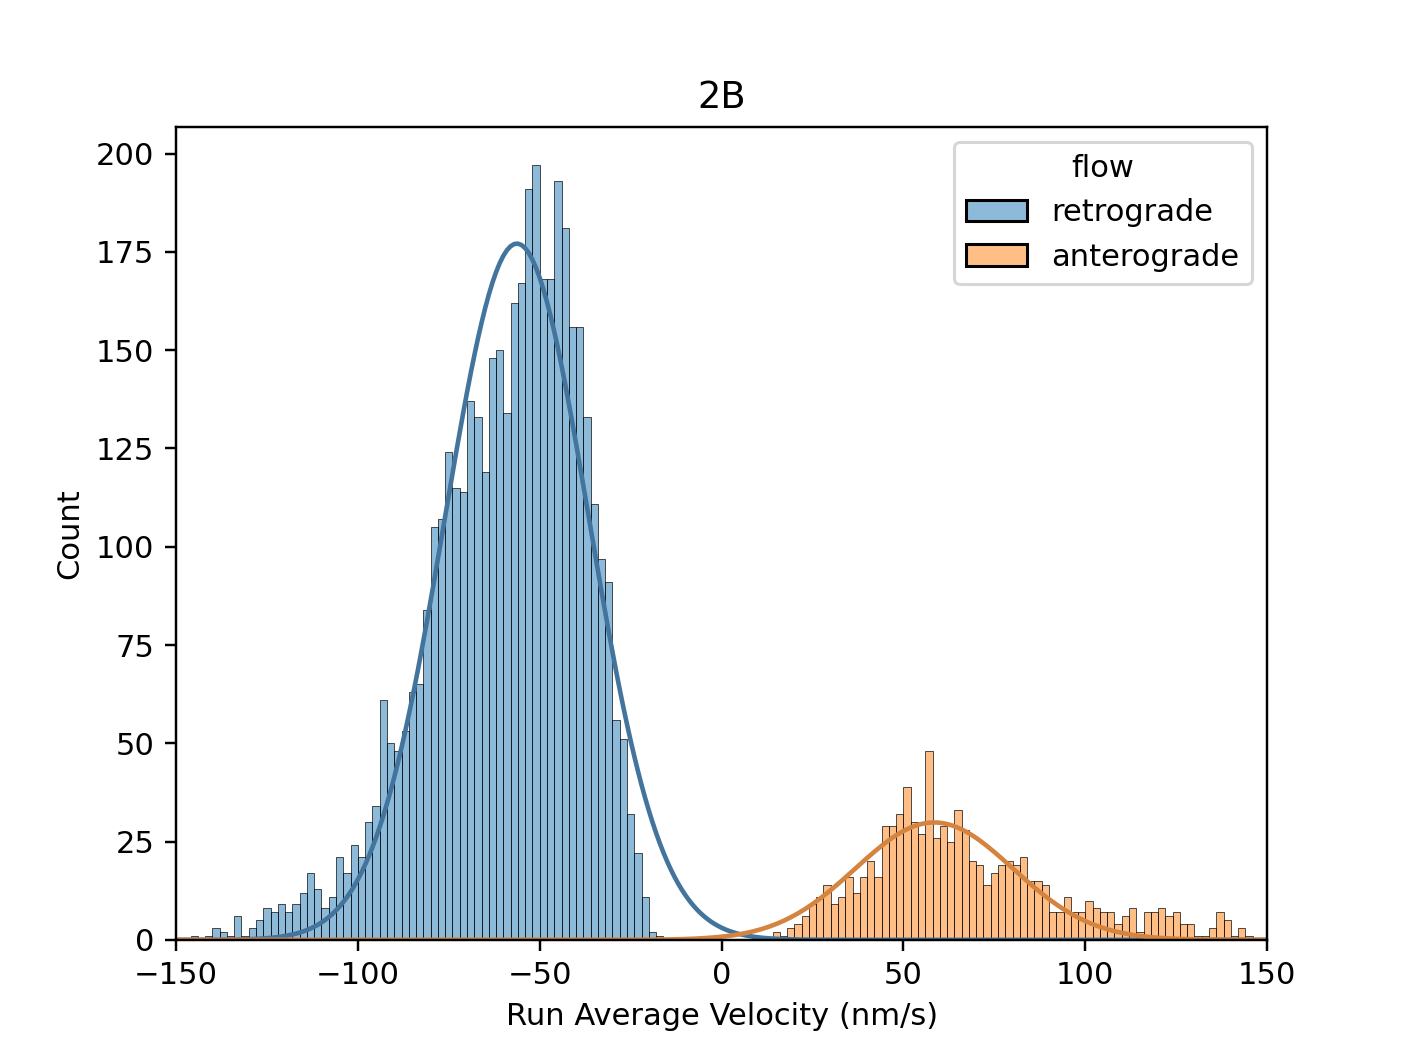

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Retrograde:  -56.28163197903379  +/-  19.768673012758203 in  4436  events   -   R^2 =  0.9385679016811461
Anterograde:  58.43759693528389  +/-  21.704440865831256 in  888  events   -   R^2 =  0.8158092520979435


In [14]:
bins = np.arange(-150,150,2)
plt.figure()
# plt.hist(all_profilin_data['signed_average_velocity'], bins=200)
sns.histplot(data = all_2a, x="signed_average_velocity", bins=bins, hue='flow')
plt.plot(retro2a_bins,retro2a_fit,color=retrograde_color)
plt.plot(antero2a_bins,antero2a_fit, color=anterograde_color)
# plt.plot(bins_retro,retro_fit,color=retrograde_color)
plt.xlim(-150,150)
plt.xlabel('Run Average Velocity (nm/s)')
plt.title('2A')
plt.show()
plt.savefig('2A_histogram.eps', format='eps')
plt.savefig('2A_histogram.png', format='png', dpi = 300)

print('Retrograde: ', retro2a_params[1], ' +/- ', retro2a_params[2], 'in ', len(retro2a), ' events   -   R^2 = ', retro2a_rsquared)
print('Anterograde: ', antero2a_params[1], ' +/- ', antero2a_params[2], 'in ', len(antero2a), ' events   -   R^2 = ', antero2a_rsquared)

plt.figure()
# plt.hist(all_profilin_data['signed_average_velocity'], bins=200)
sns.histplot(data = all_2b, x="signed_average_velocity", bins=bins, hue='flow')
plt.plot(retro2b_bins,retro2b_fit,color=retrograde_color)
plt.plot(antero2b_bins,antero2b_fit, color=anterograde_color)
# plt.plot(bins_retro,retro_fit,color=retrograde_color)
plt.xlim(-150,150)
plt.xlabel('Run Average Velocity (nm/s)')
plt.title('2B')
plt.show()
plt.savefig('2B_histogram.eps', format='eps')
plt.savefig('2B_histogram.png', format='png', dpi = 300)

print('Retrograde: ', retro2b_params[1], ' +/- ', retro2b_params[2], 'in ', len(retro2b), ' events   -   R^2 = ', retro2b_rsquared)
print('Anterograde: ', antero2b_params[1], ' +/- ', antero2b_params[2], 'in ', len(antero2b), ' events   -   R^2 = ', antero2b_rsquared)

# RLC Batch

Frame 249: 260 trajectories present.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


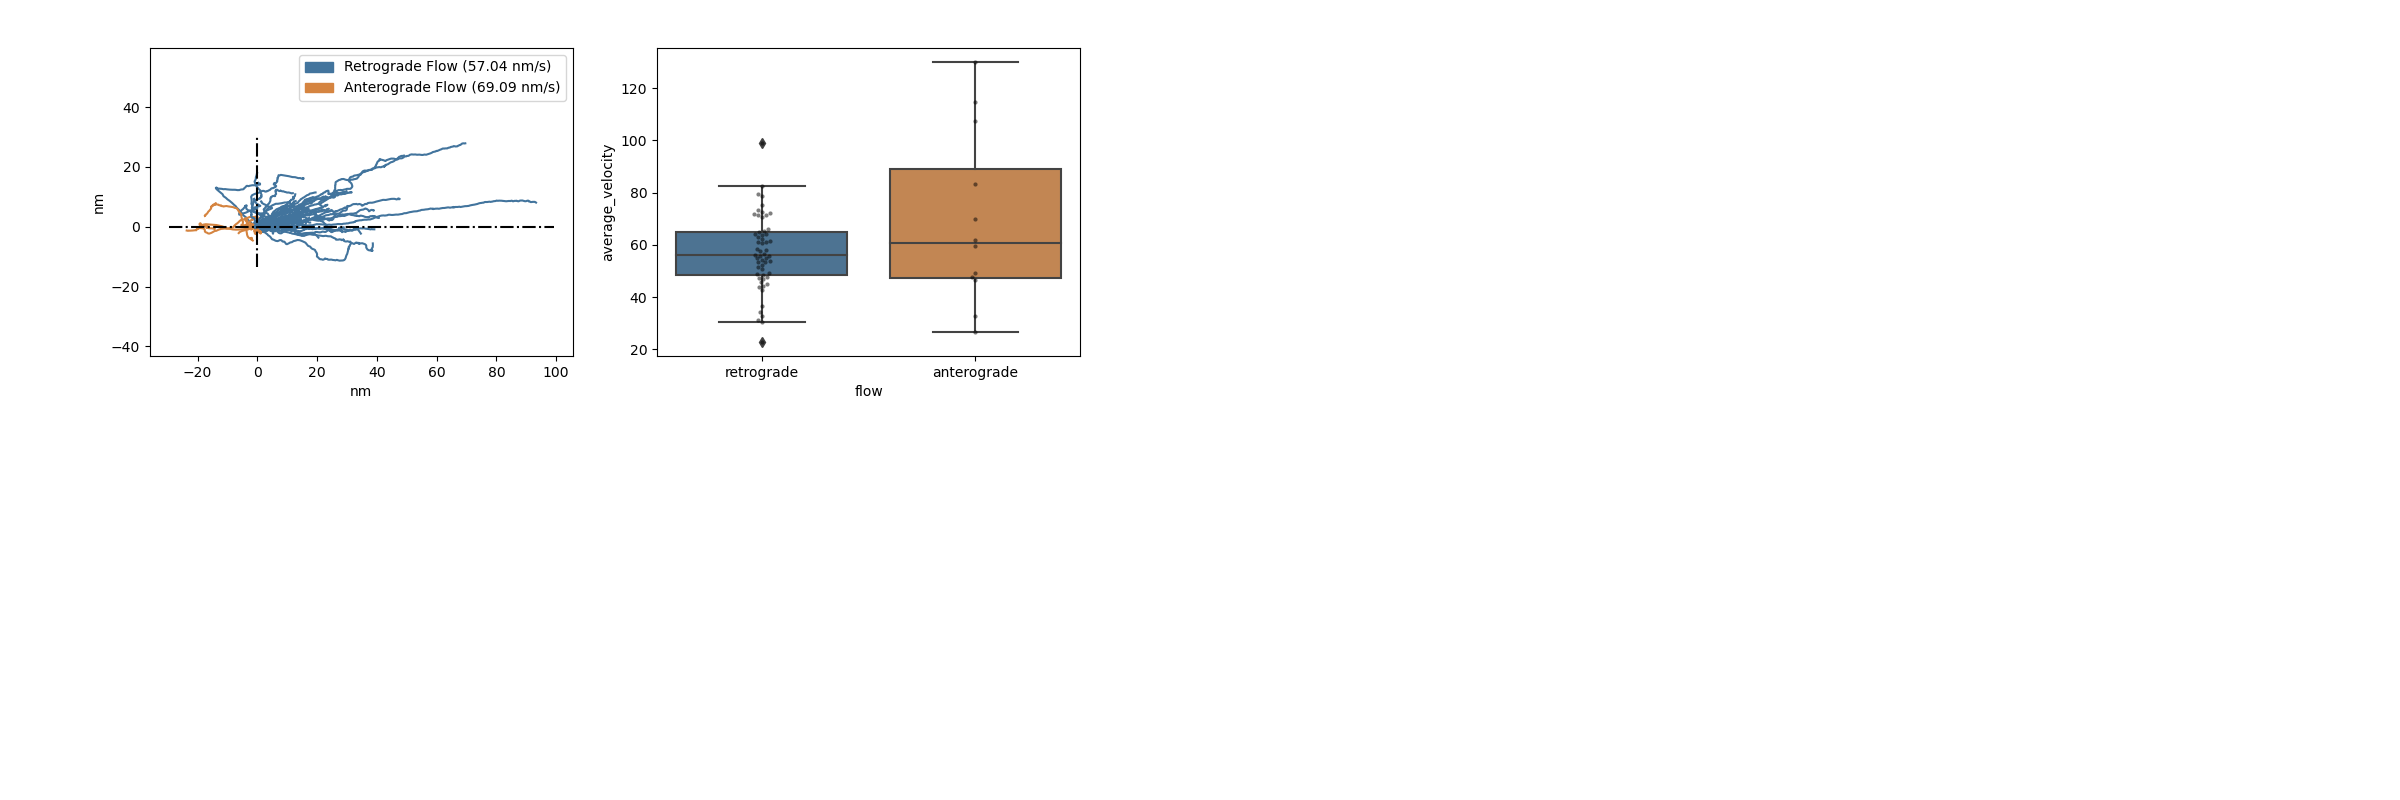

In [6]:
max_projection = False
frame_interval = 0.3
nm_per_pixel = 46.4286 # in nm
smoothing_kernel = 8 # running window average - has to change because pixel size is different
min_track_length_frames = 8 # in frames - keep it consistent with the smoothing_kernel?
number_of_skipped_frames = 2
feature_size = 11 + 2 # bigger because smaller pixel size

#filtering parameters - in pixels
filtering_kernel_size = 15
gaussian_std = 2
# peak finding parameters
min_peak_inten = 15
min_peak_distance = 5 # in pixels
# tracking parameters - all in pixels

max_feature_displacement = 5
min_track_length_nm = 900 # in nm
use_peak_image = False

# plotting colors
anterograde_color = '#d58440'
retrograde_color = '#42749d'


set_list = sorted(glob.glob('20230125_Vitriol_RLCdata/drive-download*set*'))

for dataset in set_list:
    folder_list = sorted(glob.glob(dataset + '/DUP*'))
    for folder in folder_list:
        filename = folder + folder[folder.rfind('/'):] + '.tif'
        
        # read in the image stack
        if filename[-3:] == 'tif':
            imstack = io.imread(filename)
        elif filename[-3:] == 'czi':
            imstack = czifile.czifile.imread(filename)
            imstack = np.squeeze(imstack)

        # check to see if you need to make a max projection
        if max_projection:
            imstack = np.max(imstack, axis = 1)
        
        # filter the image
        imstack_LoG = filter_image(imstack, filename, filtering_kernel_size+2, gaussian_std)
        
        # find the peaks
        all_myosin = tp.batch(imstack_LoG[:], feature_size, minmass=min_peak_inten, separation = 3)

        # check whether subpixel accuracy is decent. Should be relatively flat distribution
        tp.subpx_bias(all_myosin)
        
        # link tracks
        myosin_tracks = tp.link_df(all_myosin, search_range=max_feature_displacement, adaptive_stop = 5, memory=number_of_skipped_frames)
        # filter based on minimum length
        myosin_tracks_filtered = tp.filter_stubs(myosin_tracks, min_track_length_frames)
        
        # smooth the tracks and calculate track parameters      
        myosin_trackdata_df = calculate_trajectory_parameters2(myosin_tracks_filtered, filename, imstack[0], frame_duration=frame_interval,
                                nm_per_pixel=nm_per_pixel, smoothing_window_size=smoothing_kernel)
        
        # make plots of trajectories
        plot_valid_tracks_overlay(myosin_trackdata_df, imstack[0], filename)
        plot_trajectories_w_histogram(myosin_trackdata_df, filename)
        
        # make tracked movie
#         make_tracked_movie_stack(filename, imstack, myosin_tracks_filtered, anterograde_myosin_particles, retrograde_myosin_particles, min_inten = 35, max_inten = 4800)
        

In [14]:
all_RLC_data = pd.DataFrame()

set_list = sorted(glob.glob('20230125_Vitriol_RLCdata/drive-download*set*'))

for dataset in set_list:
    folder_list = sorted(glob.glob(dataset + '/DUP*'))
    for folder in folder_list:
        filename = folder + folder[folder.rfind('/'):] + '_filtered_trackdata.h5'
        myosin_tracks = pd.read_hdf(data_file)
        myosin_tracks['folder'] = [data_file[:data_file.find('/')]] * len(myosin_tracks)
        myosin_tracks['file'] = [data_file[data_file.rfind('/') + 1 :data_file.rfind('_filtered')]] * len(myosin_tracks)

        all_RLC_data = pd.concat([all_RLC_data, myosin_tracks])

corrected_actual_velocity_smoothed = []
for i, row in all_RLC_data.iterrows():
    if row['flow'] == 'retrograde':
        corrected_actual_velocity_smoothed.append(row['average_velocity'] * -1)
    elif row['flow'] == 'anterograde':
        corrected_actual_velocity_smoothed.append(row['average_velocity'])
    else:
        corrected_actual_velocity_smoothed.append(0)

all_RLC_data['signed_average_velocity'] = corrected_actual_velocity_smoothed

all_RLC_data = all_RLC_data.reset_index(drop=True)

# only keep the retrograde or anterograde tracks
all_RLC_data = all_RLC_data[(all_RLC_data['flow'] == 'retrograde') | (all_RLC_data['flow'] == 'anterograde')]

all_RLC_data.to_hdf('myosin_RLC_data_combined.h5', key='myosin', mode='w')


In [8]:
all_RLC_data = pd.read_hdf('myosin_RLC_data_combined.h5', key='myosin')


RLC_retro = all_RLC_data[all_RLC_data['flow'] == 'retrograde']
RLC_antero = all_RLC_data[all_RLC_data['flow'] == 'anterograde']

RLC_retro_fit, RLC_retro_bins, RLC_retro_params, RLC_retro_rsquared = gaussian_fit_line(RLC_retro['signed_average_velocity'], flow_direction = 'retrograde')
RLC_antero_fit, RLC_antero_bins, RLC_antero_params, RLC_antero_rsquared = gaussian_fit_line(RLC_antero['signed_average_velocity'], flow_direction='anterograde')

<IPython.core.display.Javascript object>


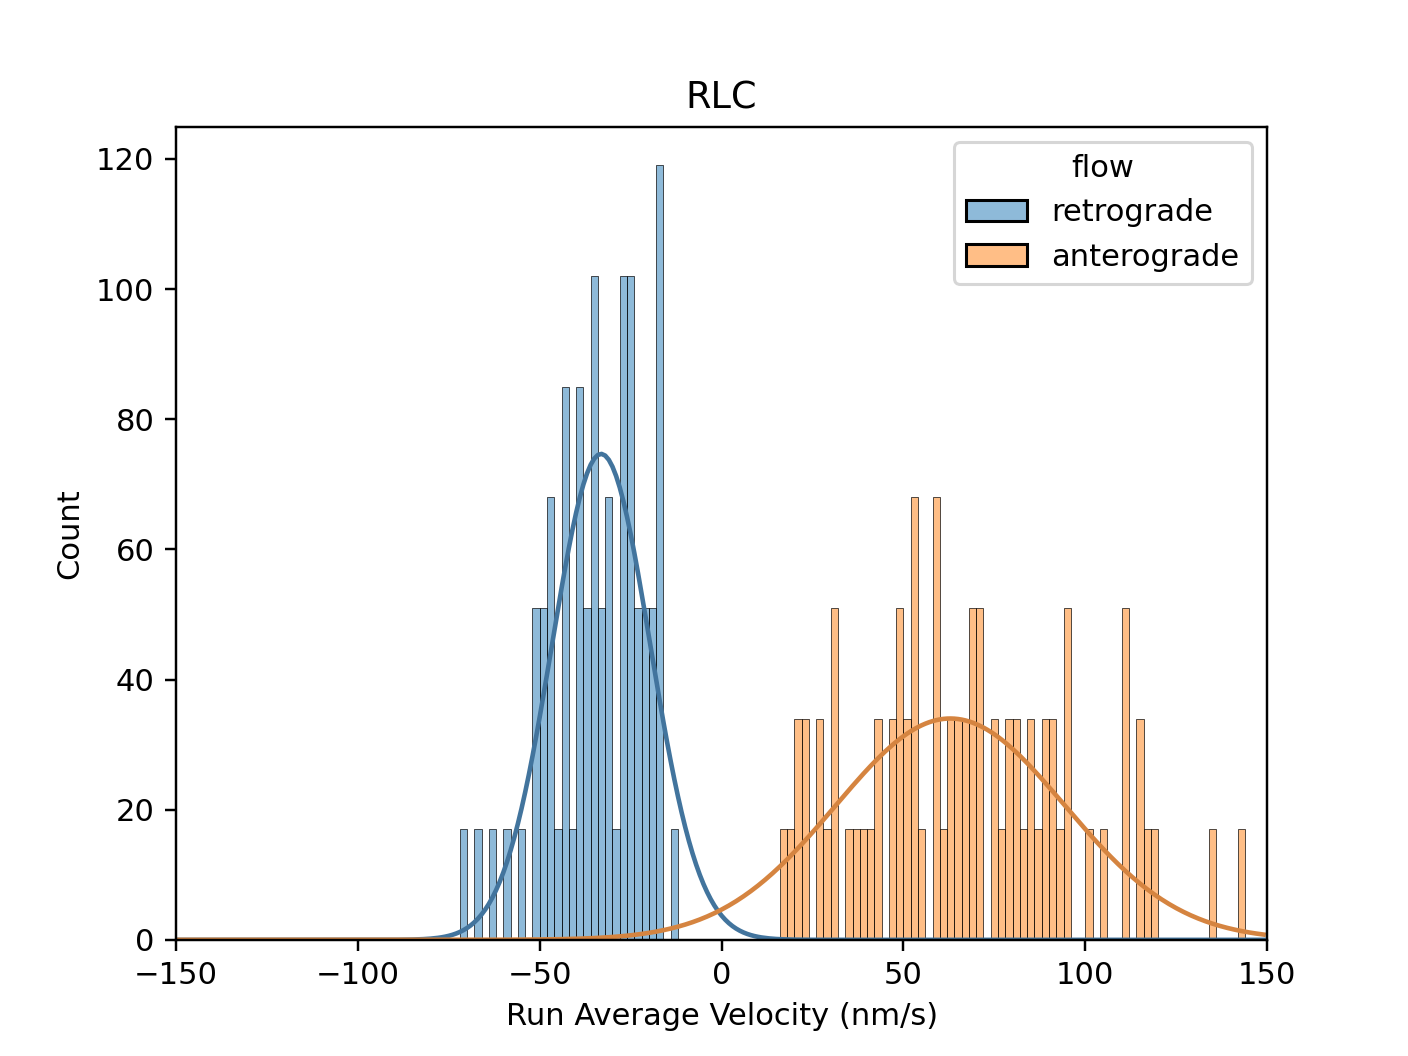

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Retrograde:  -33.123541755959856  +/-  13.524634204300748 in  1241  events   -   R^2 =  0.6655761882192434
Anterograde:  62.86554576738231  +/-  31.516304250427268 in  1343  events   -   R^2 =  0.3537066443803011


In [9]:
bins = np.arange(-150,150,2)
plt.figure()
# plt.hist(all_profilin_data['signed_average_velocity'], bins=200)
sns.histplot(data = all_RLC_data, x="signed_average_velocity", bins=bins, hue='flow')
plt.plot(RLC_retro_bins,RLC_retro_fit,color=retrograde_color)
plt.plot(RLC_antero_bins,RLC_antero_fit, color=anterograde_color)
# plt.plot(bins_retro,retro_fit,color=retrograde_color)
plt.xlim(-150,150)
plt.xlabel('Run Average Velocity (nm/s)')
plt.title('RLC')
plt.show()
plt.savefig('RLC_histogram.eps', format='eps')
plt.savefig('RLC_histogram.png', format='png', dpi = 300)

print('Retrograde: ', RLC_retro_params[1], ' +/- ', RLC_retro_params[2], 'in ', len(RLC_retro), ' events   -   R^2 = ', RLC_retro_rsquared)
print('Anterograde: ', RLC_antero_params[1], ' +/- ', RLC_antero_params[2], 'in ', len(RLC_antero), ' events   -   R^2 = ', RLC_antero_rsquared)

# Profilin data

In [3]:
# For sorting data

# folder_list = sorted(glob.glob('Profilin/profilin/set*'))
folder_list = sorted(glob.glob('Profilin/control/set*'))

for folder in folder_list:
    file_list = sorted(glob.glob(folder + '/*.tif'))
    for file in file_list:
        base = file[:file.rfind('/')]
        actual_name = file[file.rfind('/')+1:]
        folder_name = base + '/' + actual_name[:-4]
        os.mkdir(folder_name)
        shutil.move(file, folder_name)

Frame 199: 452 trajectories present.


<IPython.core.display.Javascript object>


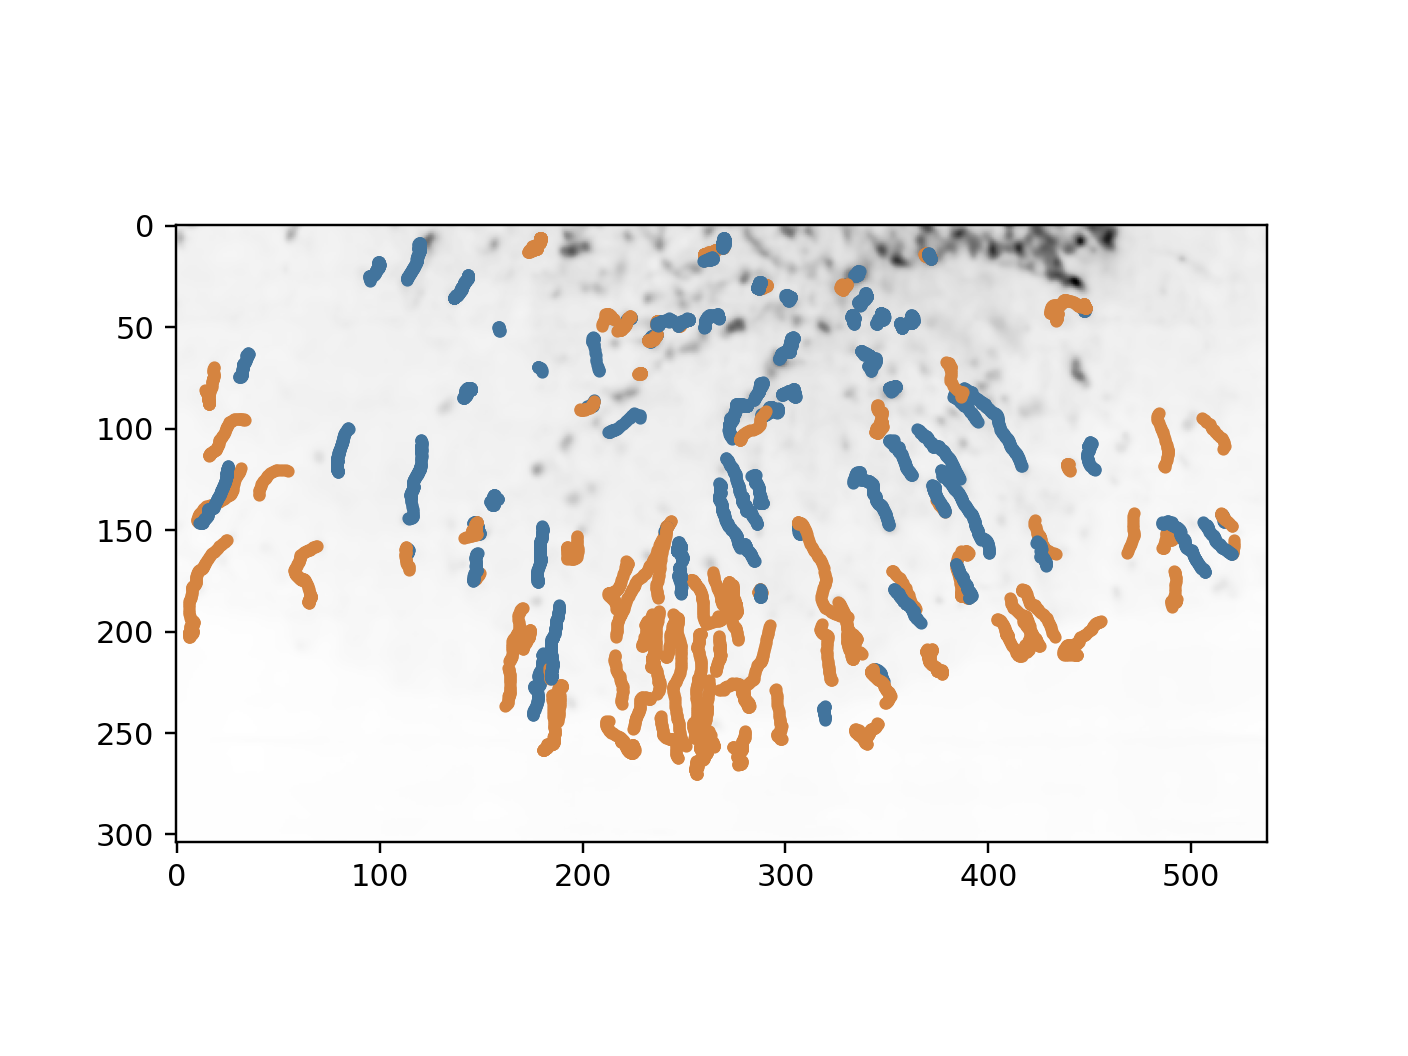

<IPython.core.display.Javascript object>


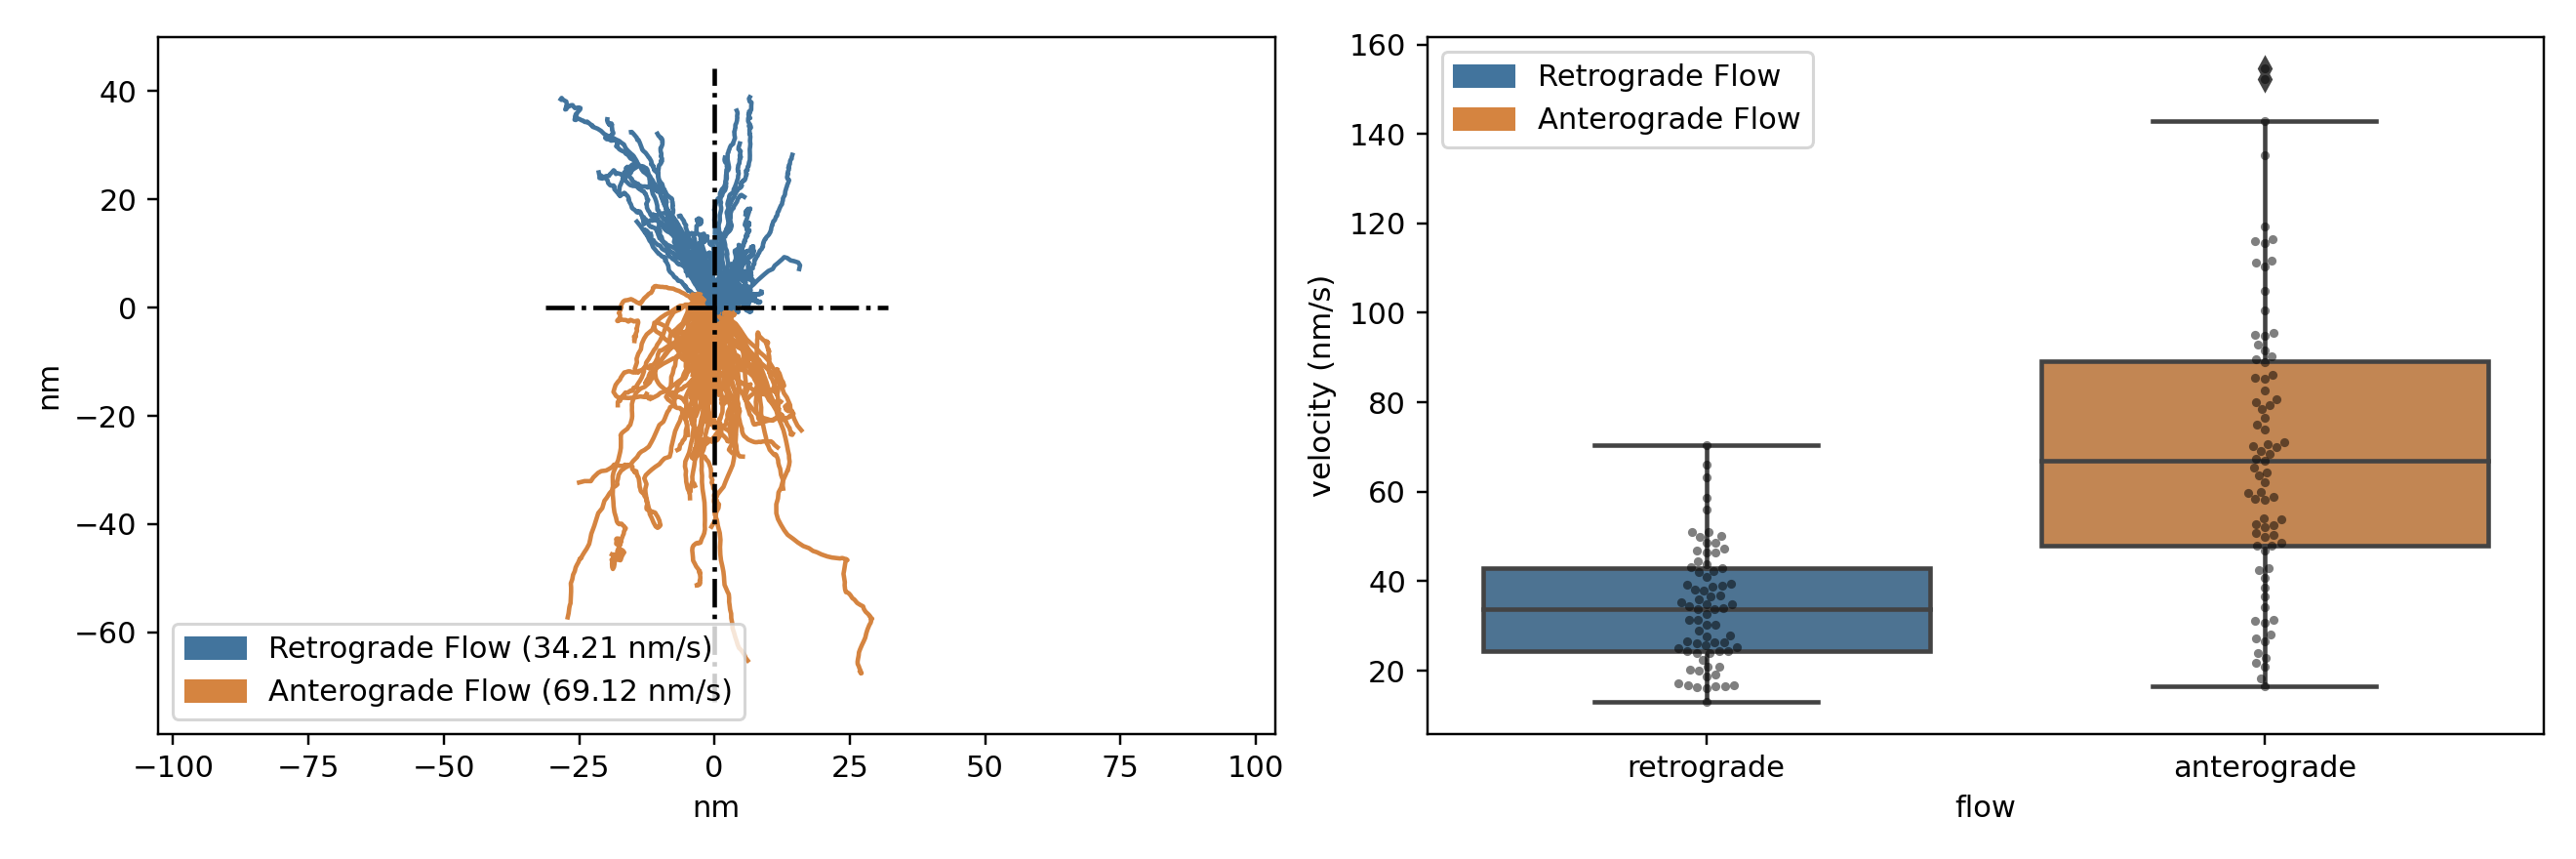

In [4]:
max_projection = False
frame_interval = 0.3
nm_per_pixel = 46.4286 # in nm
smoothing_kernel = 8 # running window average - has to change because pixel size is different
min_track_length_frames = 8 # in frames - keep it consistent with the smoothing_kernel?
number_of_skipped_frames = 2
feature_size = 11 + 2 # bigger because smaller pixel size

#filtering parameters - in pixels
filtering_kernel_size = 15
gaussian_std = 2
# peak finding parameters
min_peak_inten = 15
min_peak_distance = 5 # in pixels
# tracking parameters - all in pixels

max_feature_displacement = 5
min_track_length_nm = 900 # in nm
use_peak_image = False

# plotting colors
anterograde_color = '#d58440'
retrograde_color = '#42749d'

condition_list = ['control', 'profilin']
for condition in condition_list:
    
#     set_list = sorted(glob.glob('Profilin/profilin/set*'))
    set_list = sorted(glob.glob('Profilin/' + condition +'/set*'))

    for set_folder in set_list:
        folder_list = sorted(glob.glob(set_folder + '/DUP*'))
        for file in folder_list:
            filename = file + file[file.rfind('/'):] + '.tif'

            # read in the image stack
            if filename[-3:] == 'tif':
                imstack = io.imread(filename)
            elif filename[-3:] == 'czi':
                imstack = czifile.czifile.imread(filename)
                imstack = np.squeeze(imstack)

            # check to see if you need to make a max projection
            if max_projection:
                imstack = np.max(imstack, axis = 1)

            # filter the image
            imstack_LoG = filter_image(imstack, filename, filtering_kernel_size+2, gaussian_std)

            # find the peaks
            all_myosin = tp.batch(imstack_LoG[:], feature_size, minmass=min_peak_inten, separation = 3)

            # check whether subpixel accuracy is decent. Should be relatively flat distribution
            tp.subpx_bias(all_myosin)

            # link tracks
            myosin_tracks = tp.link_df(all_myosin, search_range=max_feature_displacement, adaptive_stop = 5, memory=number_of_skipped_frames)
            # filter based on minimum length
            myosin_tracks_filtered = tp.filter_stubs(myosin_tracks, min_track_length_frames)

            # smooth the tracks and calculate track parameters      
            myosin_trackdata_df = calculate_trajectory_parameters2(myosin_tracks_filtered, filename, imstack[0], frame_duration=frame_interval,
                                    nm_per_pixel=nm_per_pixel, smoothing_window_size=smoothing_kernel)

            # make plots of trajectories
            plot_valid_tracks_overlay(myosin_trackdata_df, imstack[0], filename)
            plot_trajectories_w_histogram(myosin_trackdata_df, filename)

            # make tracked movie
    #         make_tracked_movie_stack(filename, imstack, myosin_tracks_filtered, anterograde_myosin_particles, retrograde_myosin_particles, min_inten = 35, max_inten = 4800)


In [5]:
# round up all the profilin data
all_profilin_data = pd.DataFrame()

set_list = sorted(glob.glob('Profilin/profilin/set*'))

for set_folder in set_list:
    folder_list = sorted(glob.glob(set_folder + '/DUP*'))
    for file in folder_list:
        data_file = file + file[file.rfind('/'):] + '_filtered_trackdata.h5'
        myosin_tracks = pd.read_hdf(data_file)
        myosin_tracks['folder'] = [data_file[:data_file.find('/')]] * len(myosin_tracks)
        myosin_tracks['file'] = [data_file[data_file.rfind('/') + 1 :data_file.rfind('Denoised')]] * len(myosin_tracks)
        # myosin_tracks.head()
        all_profilin_data = pd.concat([all_profilin_data, myosin_tracks])


corrected_actual_velocity_smoothed = []
for i, row in all_profilin_data.iterrows():
    if row['flow'] == 'retrograde':
        corrected_actual_velocity_smoothed.append(row['average_velocity'] * -1)
    elif row['flow'] == 'anterograde':
        corrected_actual_velocity_smoothed.append(row['average_velocity'])
    else:
        corrected_actual_velocity_smoothed.append(0)

all_profilin_data['signed_average_velocity'] = corrected_actual_velocity_smoothed

all_profilin_data = all_profilin_data.reset_index(drop=True)

# only keep the retrograde or anterograde tracks
all_profilin_data = all_profilin_data[(all_profilin_data['flow'] == 'retrograde') | (all_profilin_data['flow'] == 'anterograde')]

all_profilin_data.to_hdf('profilin_data_combined.h5', key='myosin', mode='w')


In [6]:
# round up all the control data
all_gfpcontrol_data = pd.DataFrame()

set_list = sorted(glob.glob('Profilin/control/set*'))

for set_folder in set_list:
    folder_list = sorted(glob.glob(set_folder + '/DUP*'))
    for file in folder_list:
        data_file = file + file[file.rfind('/'):] + '_filtered_trackdata.h5'
        myosin_tracks = pd.read_hdf(data_file)
        myosin_tracks['folder'] = [data_file[:data_file.find('/')]] * len(myosin_tracks)
        myosin_tracks['file'] = [data_file[data_file.rfind('/') + 1 :data_file.rfind('Denoised')]] * len(myosin_tracks)
        # myosin_tracks.head()
        all_gfpcontrol_data = pd.concat([all_gfpcontrol_data, myosin_tracks])


corrected_actual_velocity_smoothed = []
for i, row in all_gfpcontrol_data.iterrows():
    if row['flow'] == 'retrograde':
        corrected_actual_velocity_smoothed.append(row['average_velocity'] * -1)
    elif row['flow'] == 'anterograde':
        corrected_actual_velocity_smoothed.append(row['average_velocity'])
    else:
        corrected_actual_velocity_smoothed.append(0)

all_gfpcontrol_data['signed_average_velocity'] = corrected_actual_velocity_smoothed

all_gfpcontrol_data = all_gfpcontrol_data.reset_index(drop=True)

# only keep the retrograde or anterograde tracks
all_gfpcontrol_data = all_gfpcontrol_data[(all_gfpcontrol_data['flow'] == 'retrograde') | (all_gfpcontrol_data['flow'] == 'anterograde')]

all_gfpcontrol_data.to_hdf('gfpcontrol_data_combined.h5', key='myosin', mode='w')

In [2]:
# read in the file
all_profilin_data = pd.read_hdf('profilin_data_combined.h5', key='myosin')

profilin_retro = all_profilin_data[all_profilin_data['flow'] == 'retrograde']
profilin_antero = all_profilin_data[all_profilin_data['flow'] == 'anterograde']

profilin_retro_fit, profilin_retro_bins, profilin_retro_params, profilin_retro_rsquared = gaussian_fit_line(profilin_retro['signed_average_velocity'], flow_direction = 'retrograde')
profilin_antero_fit, profilin_antero_bins, profilin_antero_params, profilin_antero_rsquared = gaussian_fit_line(profilin_antero['signed_average_velocity'], flow_direction='anterograde')

all_gfpcontrol_data = pd.read_hdf('gfpcontrol_data_combined.h5', key='myosin')

gfpcontrol_retro = all_gfpcontrol_data[all_gfpcontrol_data['flow'] == 'retrograde']
gfpcontrol_antero = all_gfpcontrol_data[all_gfpcontrol_data['flow'] == 'anterograde']

gfpcontrol_retro_fit, gfpcontrol_retro_bins,gfpcontrol_retro_params, gfpcontrol_retro_rsquared = gaussian_fit_line(gfpcontrol_retro['signed_average_velocity'], flow_direction = 'retrograde')
gfpcontrol_antero_fit, gfpcontrol_antero_bins, gfpcontrol_antero_params, gfpcontrol_antero_rsquared = gaussian_fit_line(gfpcontrol_antero['signed_average_velocity'], flow_direction='anterograde')

<IPython.core.display.Javascript object>


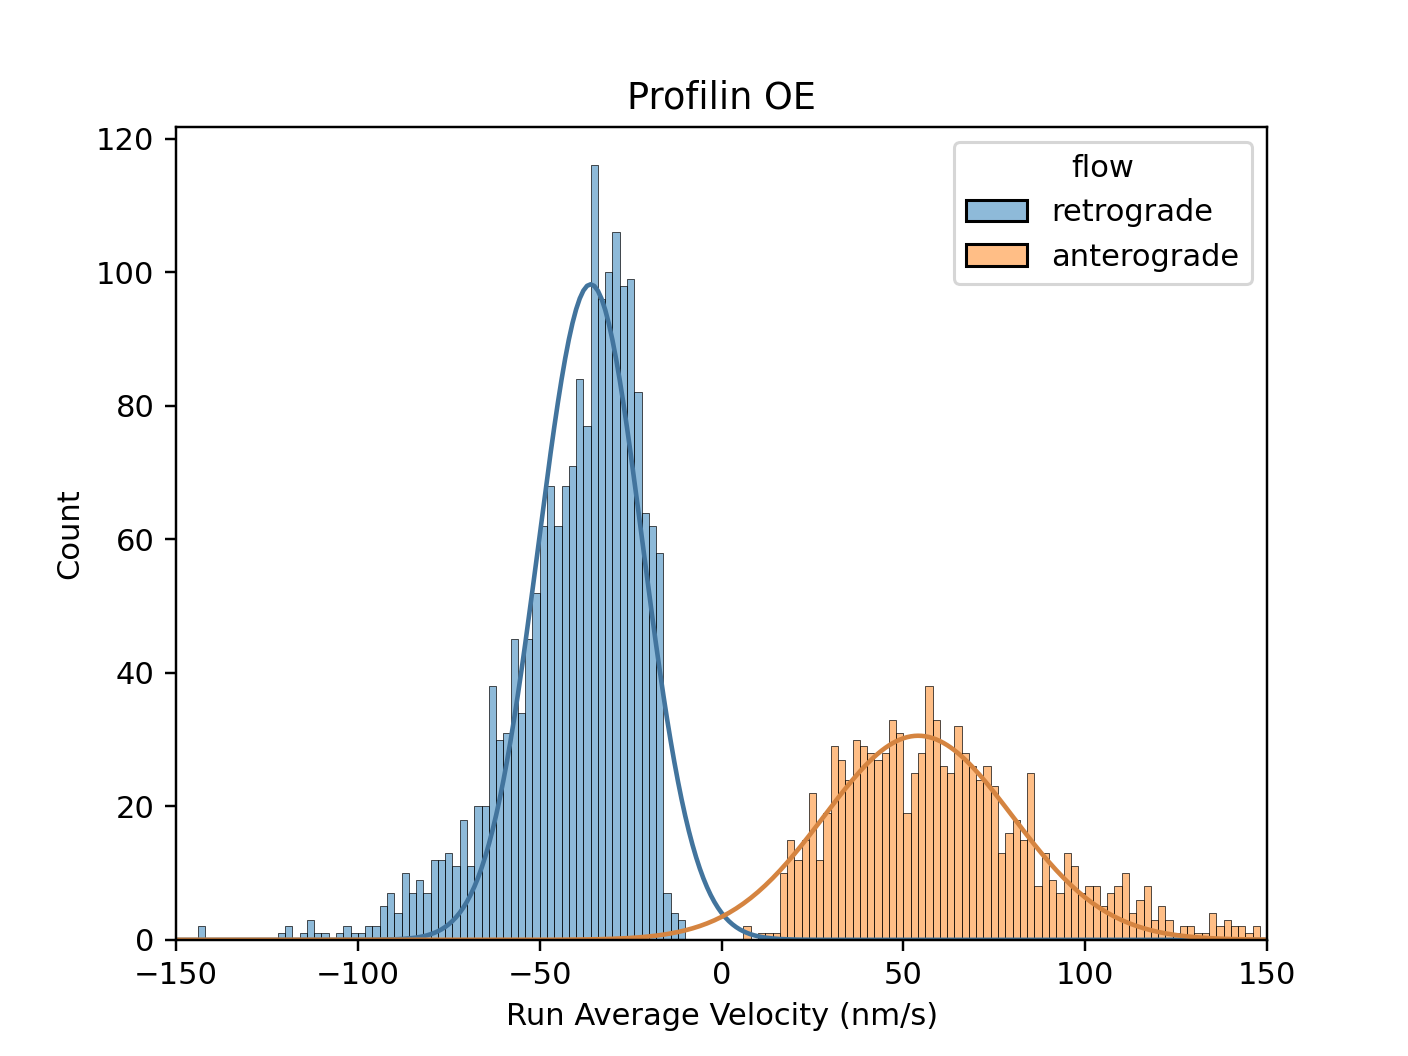

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Retrograde:  -36.016811108842816  +/-  14.254302535713624 in  1848  events   -   R^2 =  0.9034529164980438
Anterograde:  54.066354921127186  +/-  25.871479441066317 in  1012  events   -   R^2 =  0.8607041668720097


<IPython.core.display.Javascript object>


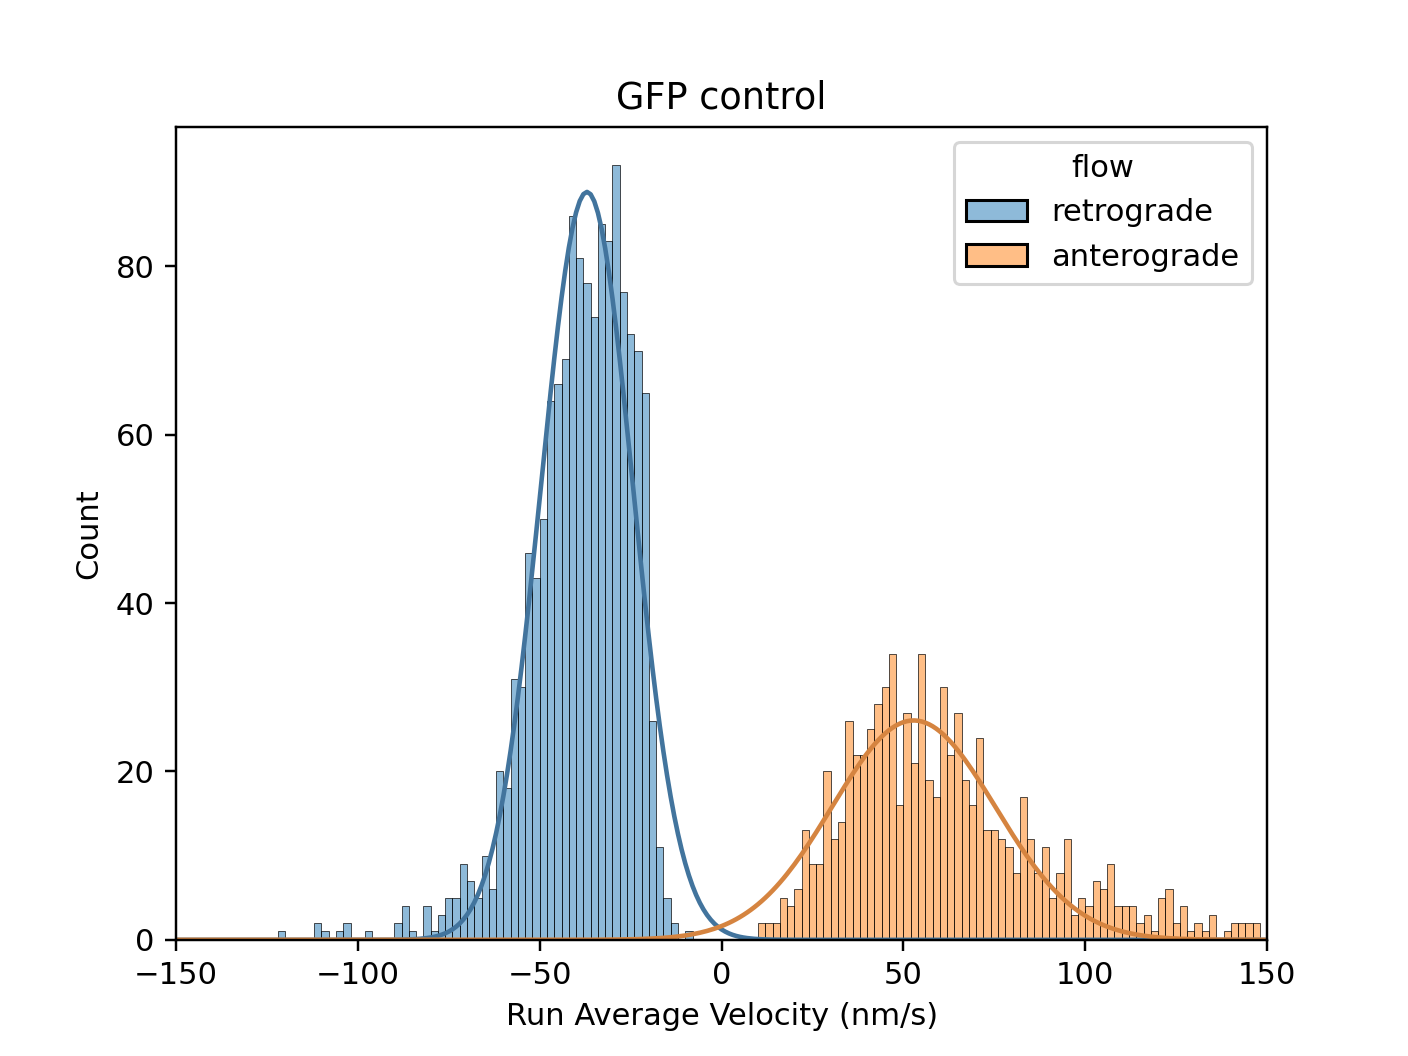

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Retrograde:  -37.01675148490012  +/-  12.655061281455442 in  1418  events   -   R^2 =  0.9493540853428014
Anterograde:  52.80582322349382  +/-  22.441604334614112 in  783  events   -   R^2 =  0.8186007052412079


In [6]:
bins = np.arange(-150,150,2)
plt.figure()
sns.histplot(data = all_profilin_data, x="signed_average_velocity", bins=bins, hue='flow')
plt.plot(profilin_retro_bins,profilin_retro_fit,color=retrograde_color)
plt.plot(profilin_antero_bins,profilin_antero_fit, color=anterograde_color)
plt.xlim(-150,150)
plt.xlabel('Run Average Velocity (nm/s)')
plt.title('Profilin OE')
plt.show()
plt.savefig('profilin_histogram.eps', format='eps')
plt.savefig('profilin_histogram.png', format='png', dpi = 300)

print('Retrograde: ', profilin_retro_params[1], ' +/- ', profilin_retro_params[2], 'in ', len(profilin_retro), ' events   -   R^2 = ', profilin_retro_rsquared)
print('Anterograde: ', profilin_antero_params[1], ' +/- ', profilin_antero_params[2], 'in ', len(profilin_antero), ' events   -   R^2 = ', profilin_antero_rsquared)

hue_order = ['retrograde', 'anterograde']
plt.figure()
sns.histplot(data = all_gfpcontrol_data, x="signed_average_velocity", bins=bins, hue='flow', hue_order = hue_order)
plt.plot(gfpcontrol_retro_bins,gfpcontrol_retro_fit,color=retrograde_color)
plt.plot(gfpcontrol_antero_bins,gfpcontrol_antero_fit, color=anterograde_color)
plt.xlim(-150,150)
plt.xlabel('Run Average Velocity (nm/s)')
plt.title('GFP control')
plt.show()
plt.savefig('gfpcontrol_histogram.eps', format='eps')
plt.savefig('gfpcontrol_histogram.png', format='png', dpi = 300)

print('Retrograde: ', gfpcontrol_retro_params[1], ' +/- ', gfpcontrol_retro_params[2], 'in ', len(gfpcontrol_retro), ' events   -   R^2 = ', gfpcontrol_retro_rsquared)
print('Anterograde: ', gfpcontrol_antero_params[1], ' +/- ', gfpcontrol_antero_params[2], 'in ', len(gfpcontrol_antero), ' events   -   R^2 = ', gfpcontrol_antero_rsquared)

# Statistics


In [63]:
all_data = pd.read_hdf('myosin_2A_and_2B_all_data_combined.h5', key='myosin')

all_2a = all_data[all_data['folder'] == '2A_Halo']
all_2b = all_data[all_data['folder'] == '2B_Halo']

retro2a = all_2a[all_2a['flow'] == 'retrograde']
antero2a = all_2a[all_2a['flow'] == 'anterograde']

all_RLC_data = pd.read_hdf('myosin_RLC_data_combined.h5', key='myosin')


retroRLC = all_RLC_data[all_RLC_data['flow'] == 'retrograde']
anteroRLC = all_RLC_data[all_RLC_data['flow'] == 'anterograde']

all_profilin_data = pd.read_hdf('profilin_data_combined.h5', key='myosin')

retroProfilin = all_profilin_data[all_profilin_data['flow'] == 'retrograde']
anteroProfilin = all_profilin_data[all_profilin_data['flow'] == 'anterograde']


In [64]:
from scipy import stats

In [82]:
retro_data_list = [retro2a, retro2b, retroRLC, retroProfilin]
antero_data_list = [antero2a, antero2b, anteroRLC, anteroProfilin]
res_mat = np.zeros((4,4))
p_mat = np.zeros((4,4))

for i, retro_data in enumerate(retro_data_list):
    for j, antero_data in enumerate(antero_data_list):
#         res, p = stats.mannwhitneyu(retro_data['signed_average_velocity'], antero_data['signed_average_velocity'])
        res, p = stats.brunnermunzel(retro_data['signed_average_velocity'], antero_data['signed_average_velocity'], distribution='normal')

        res_mat[i,j] = res
        p_mat[i,j] = p
        
print(p_mat) 
print(res_mat)
# r, p = stats.mannwhitneyu(antero2b['signed_average_velocity'], antero2a['signed_average_velocity'])
# print(r)
# print(p)
# result = []
# for d in retro_data_list:
#     result.append(stats.shapiro(d['signed_average_velocity']))
# for d in antero_data_list:
#     result.append(stats.shapiro(d['signed_average_velocity']))
# for r in result:
#     print(result)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]


/Users/poakes/opt/anaconda3/envs/tfm/lib/python3.11/site-packages/scipy/stats/_stats_py.py:8494: RuntimeWarning: divide by zero encountered in double_scalars
  wbfn /= (nx + ny) * np.sqrt(nx * Sx + ny * Sy)


# Figure 1 Movie

In [3]:
filename = 'Fig1_movie/DUP_ND Acquisition 02 - Denoise_ai.nd2 - Deconvolved 5 iterations, Type Blind-1_rotate_cropped.tif'

In [30]:
max_projection = False
frame_interval = 0.33
nm_per_pixel = 23.214 # in nm
smoothing_kernel = 8 # running window average - has to change because pixel size is different
min_track_length_frames = 8 # in frames - keep it consistent with the smoothing_kernel?
number_of_skipped_frames = 2
feature_size = 11 + 2 # bigger because smaller pixel size

#filtering parameters - in pixels
filtering_kernel_size = 15
gaussian_std = 2
# peak finding parameters
min_peak_inten = 15
min_peak_distance = 5 # in pixels
# tracking parameters - all in pixels

max_feature_displacement = 5
min_track_length_nm = 300 # in nm
use_peak_image = False

# plotting colors
anterograde_color = '#d58440'
retrograde_color = '#42749d'

In [6]:
imstack = io.imread(filename).astype('float32')
# filter the image
imstack_LoG = filter_image(imstack, filename, filtering_kernel_size+2, gaussian_std)


In [29]:
# find the peaks
all_myosin = tp.batch(imstack_LoG[:], feature_size - 4, minmass=min_peak_inten, separation = 3)


Frame 199: 589 features


<IPython.core.display.Javascript object>


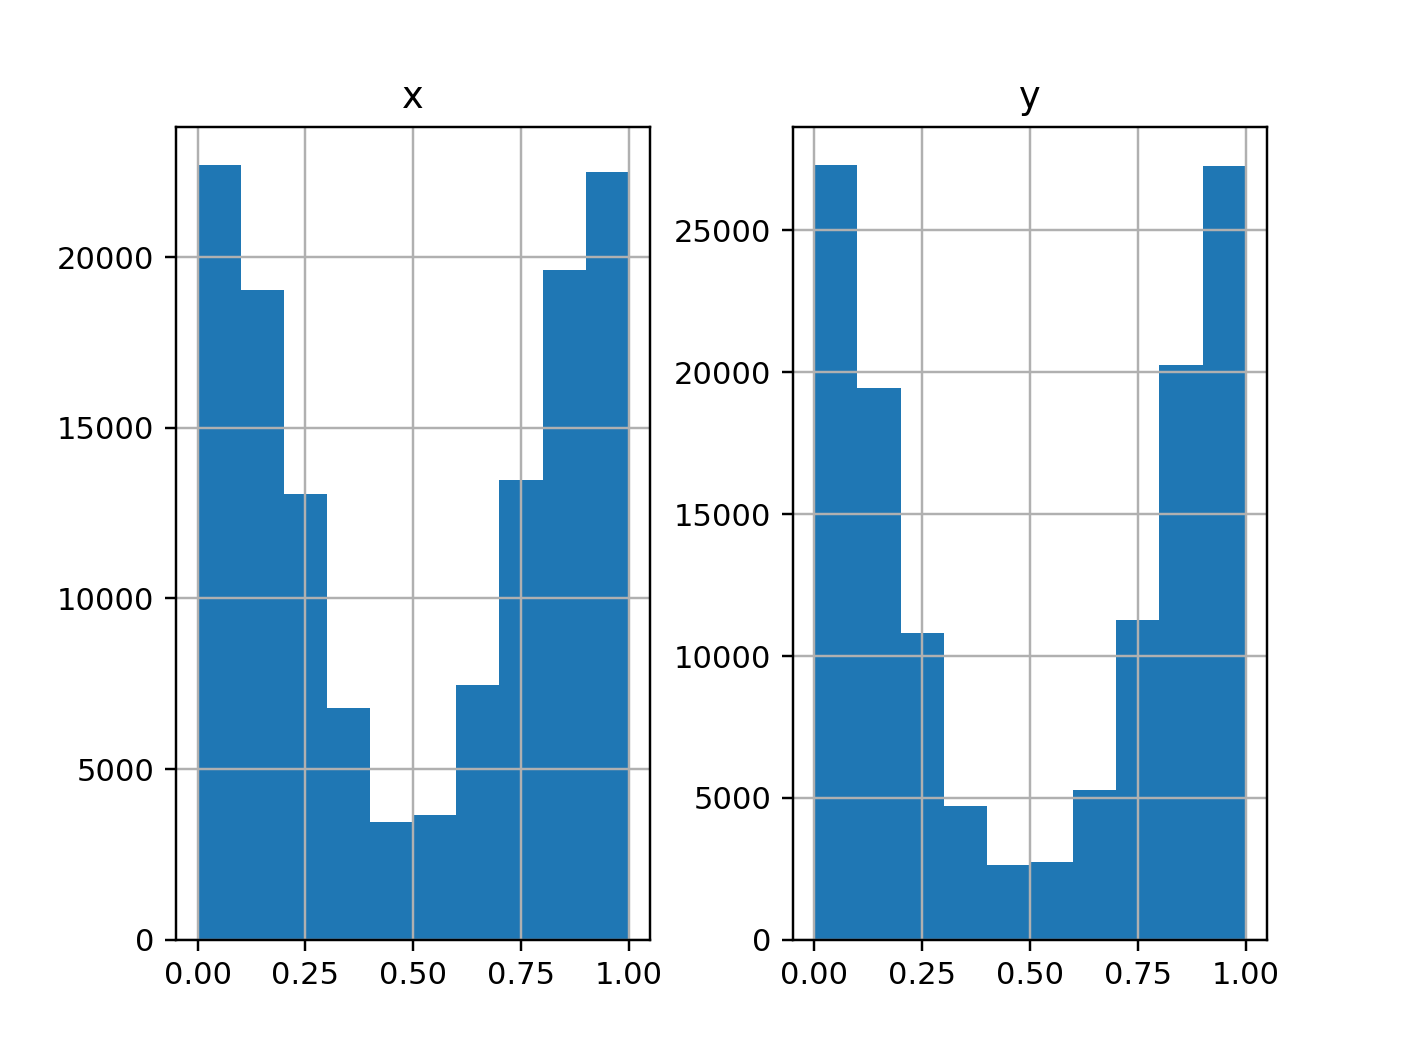

array([[<AxesSubplot: title={'center': 'x'}>,
        <AxesSubplot: title={'center': 'y'}>]], dtype=object)

In [31]:
# check whether subpixel accuracy is decent. Should be relatively flat distribution
tp.subpx_bias(all_myosin)


In [32]:
# link tracks
myosin_tracks = tp.link_df(all_myosin, search_range=max_feature_displacement, adaptive_stop = 5, memory=number_of_skipped_frames)


Frame 199: 589 trajectories present.


In [33]:
# filter based on minimum length
myosin_tracks_filtered = tp.filter_stubs(myosin_tracks, min_track_length_frames)


In [34]:
# smooth the tracks and calculate track parameters      
myosin_trackdata_df = calculate_trajectory_parameters2(myosin_tracks_filtered, filename, imstack[0], frame_duration=frame_interval,
                        nm_per_pixel=nm_per_pixel, smoothing_window_size=smoothing_kernel)


<IPython.core.display.Javascript object>


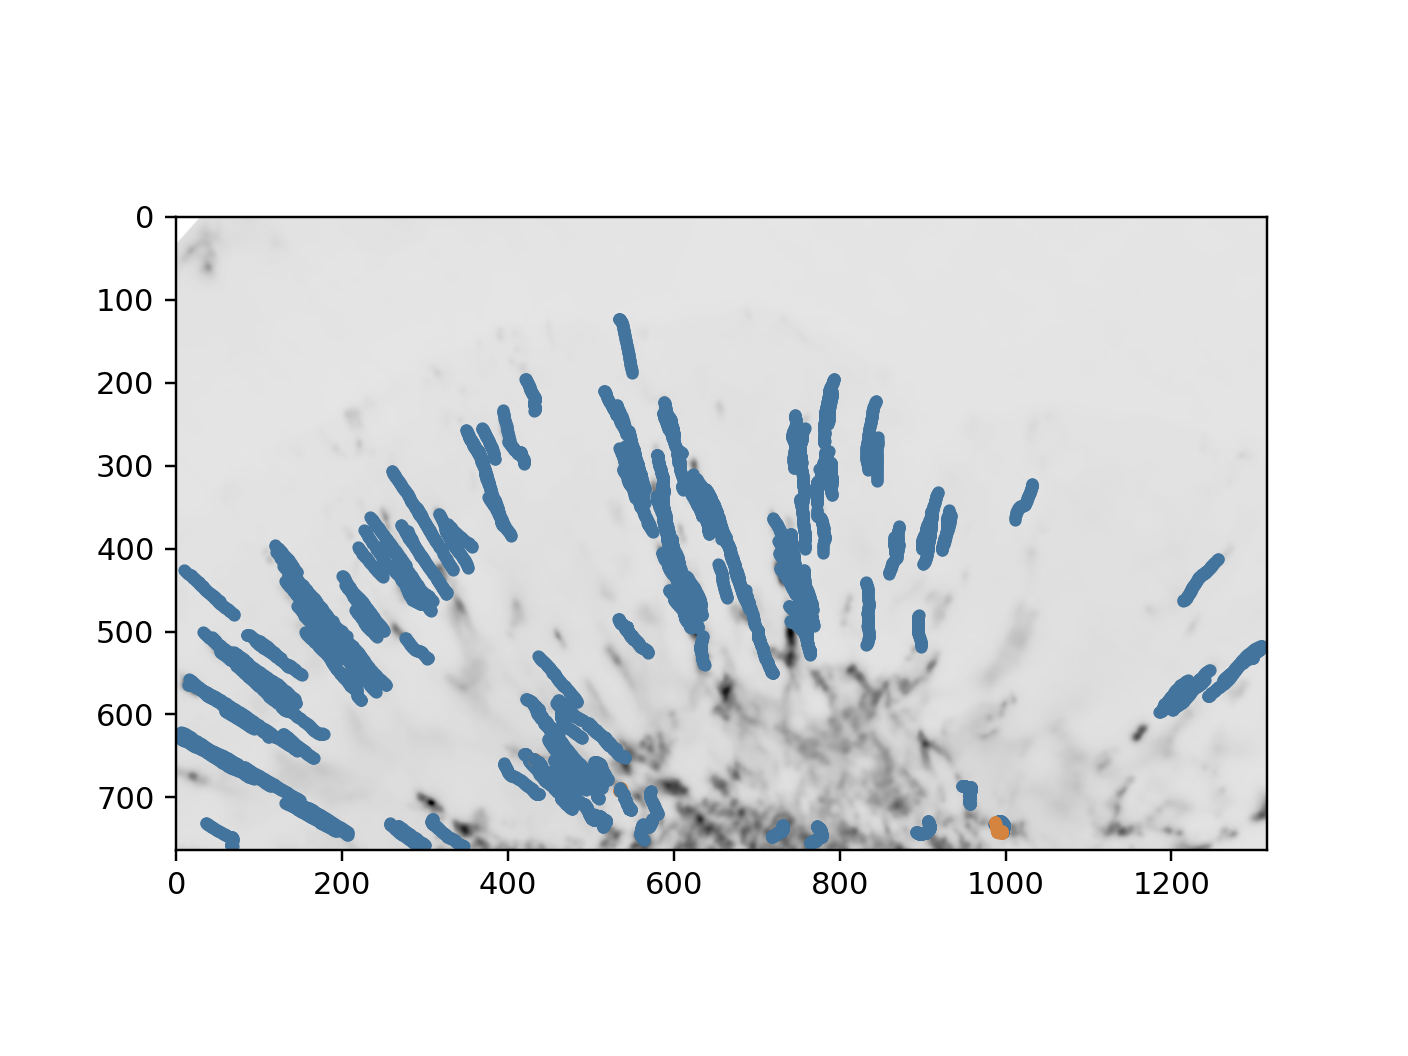

In [35]:
# make plots of trajectories
plot_valid_tracks_overlay(myosin_trackdata_df, imstack[0], filename)

<IPython.core.display.Javascript object>


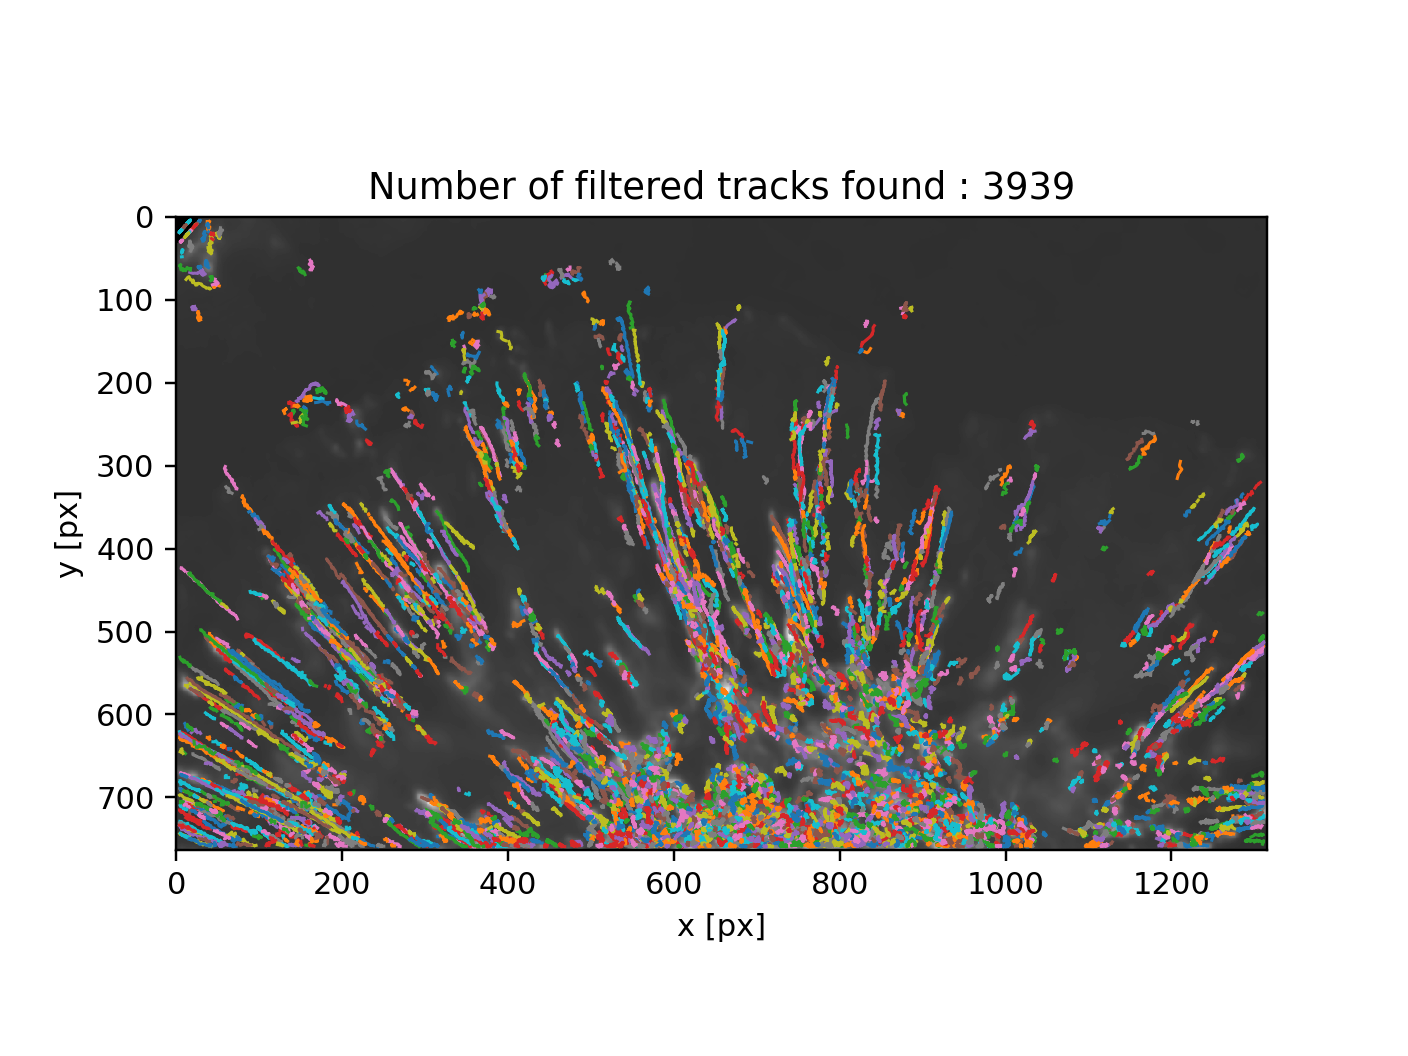

In [36]:
plot_track_overlays(myosin_tracks_filtered, filename, imstack)

<IPython.core.display.Javascript object>


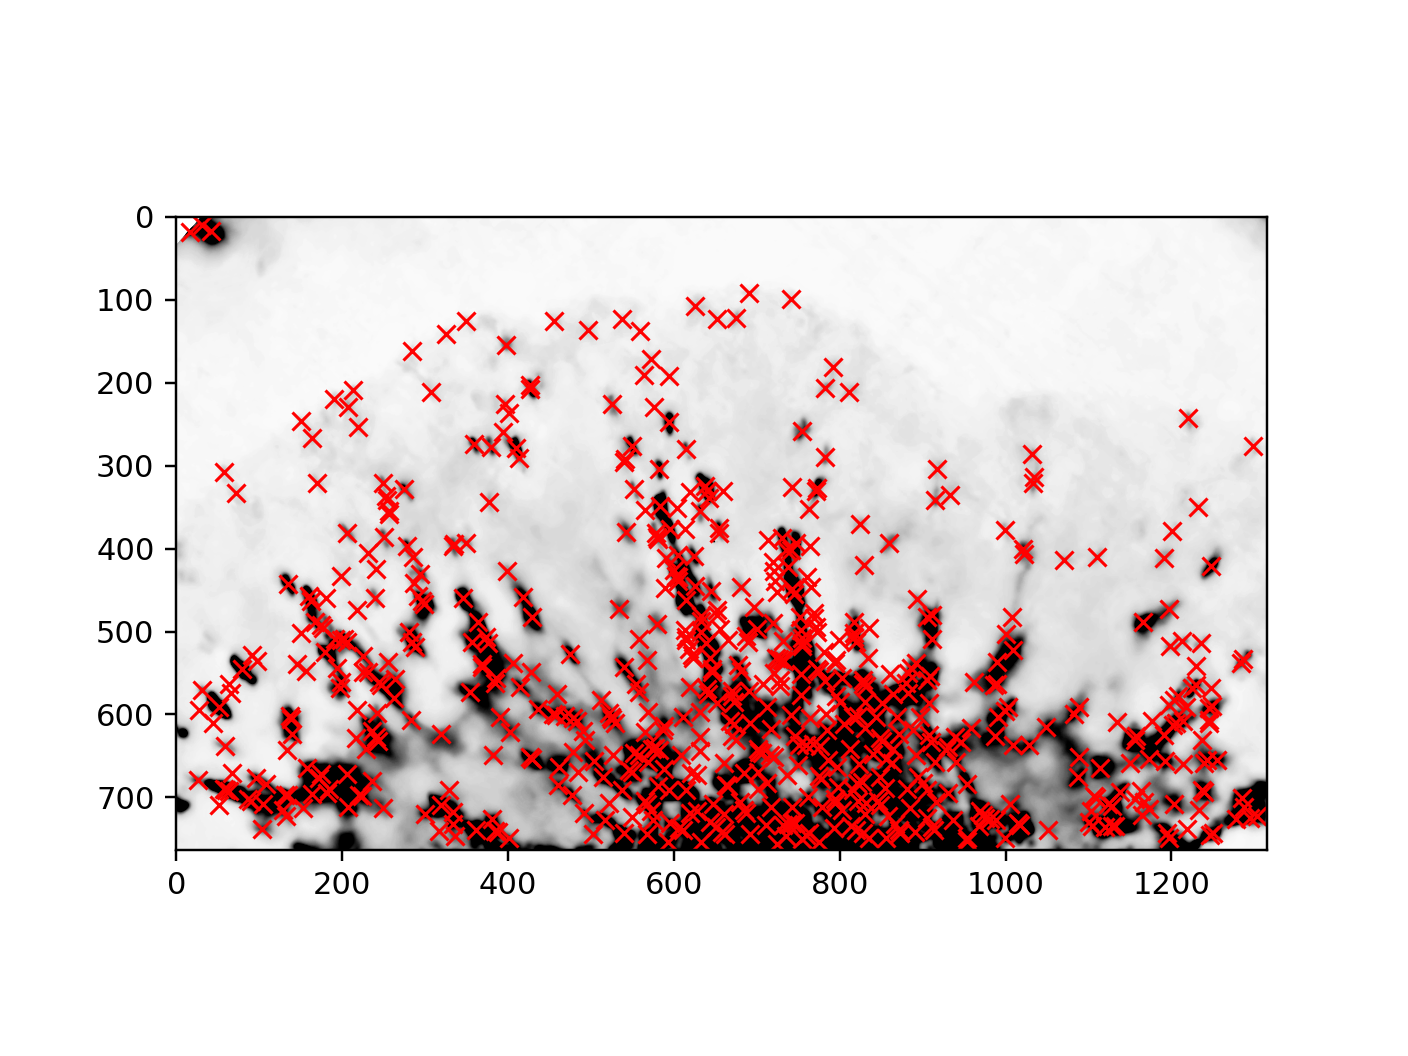

In [21]:
frame = 41
potential_myosin = tp.locate(imstack_LoG[frame], feature_size+12, minmass=15, separation = 3)
# potential_myosin.head()

x = potential_myosin['x'].values
y = potential_myosin['y'].values
mass = potential_myosin['mass'].values
size = potential_myosin['size'].values
ecc = potential_myosin['ecc'].values
signal = potential_myosin['signal'].values
raw_mass = potential_myosin['raw_mass'].values
ep = potential_myosin['ep'].values

plt.figure()
plt.imshow(imstack[frame], cmap='Greys', vmin=96, vmax=180)
for i in np.arange(0,len(x)):
    plt.plot(x[i],y[i],'rx')
#     plt.text(x[i]+4,y[i]+4,str(np.round(size[i],2)), color='green')

plt.show()

<IPython.core.display.Javascript object>


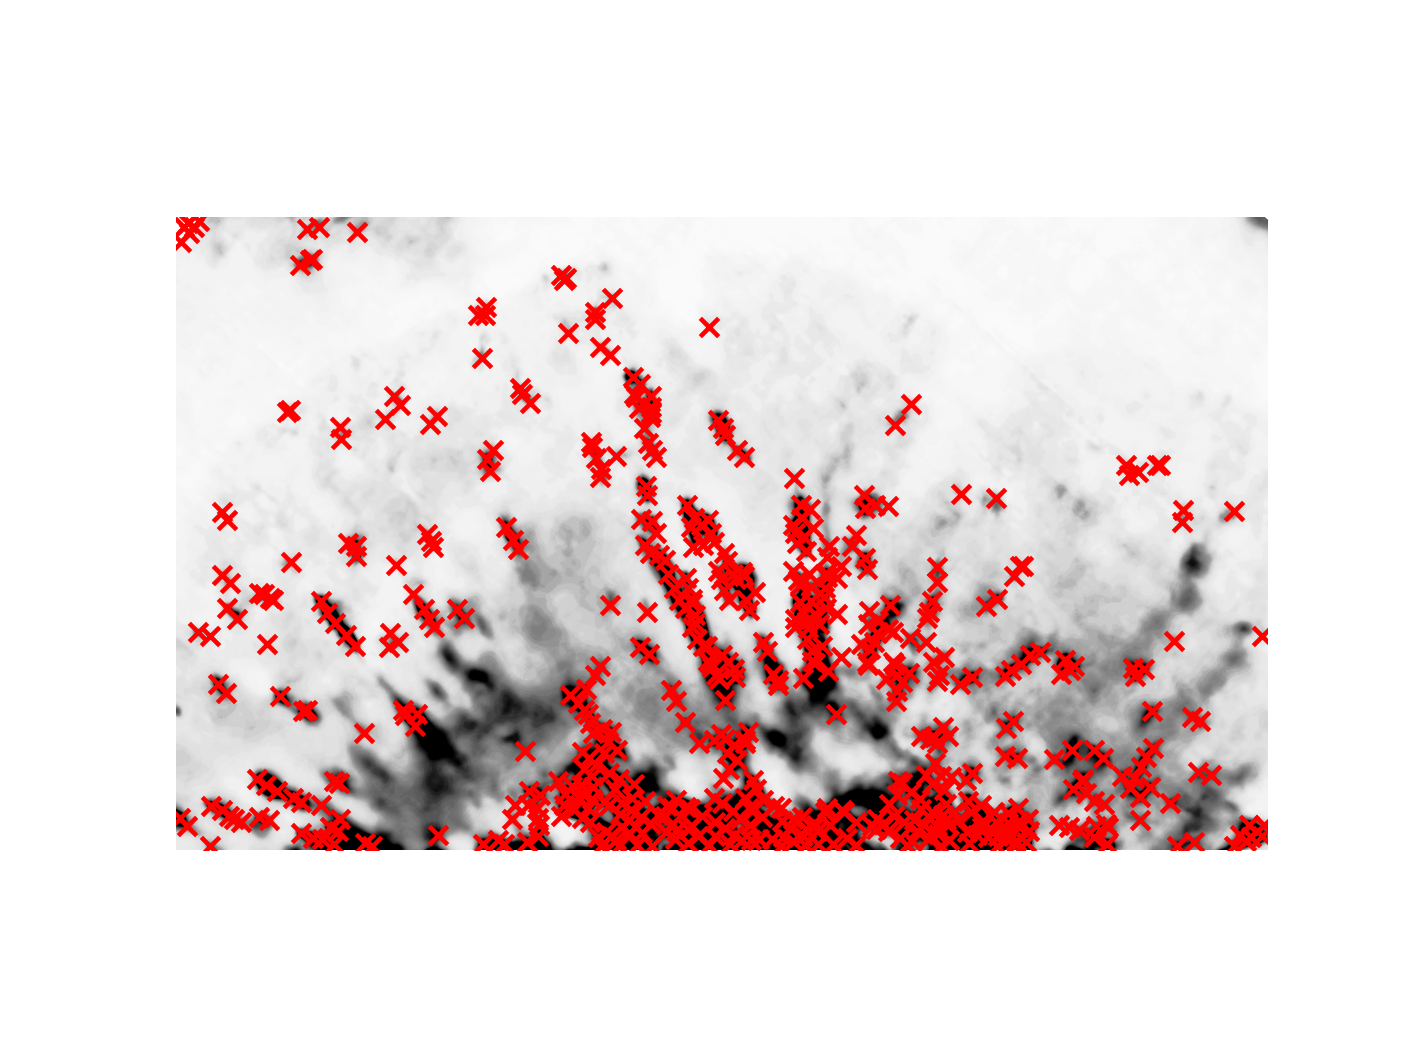

In [37]:
make_movie_with_all_peaks(imstack, filename, all_myosin, min_im_inten=96, max_im_inten=180)

<IPython.core.display.Javascript object>


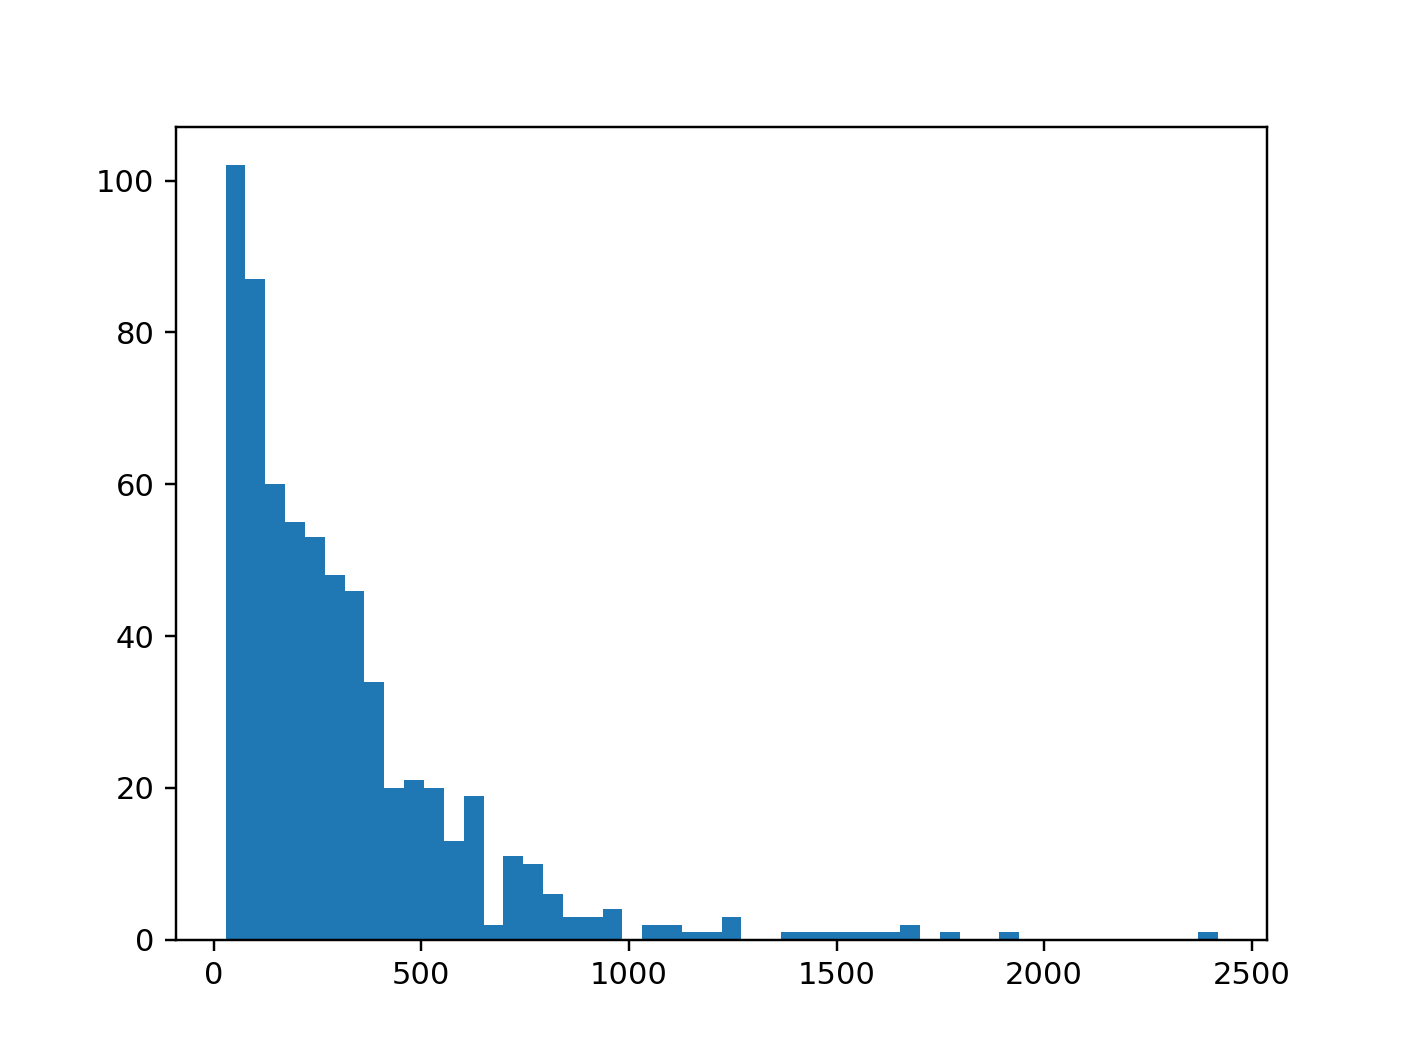

In [22]:
plt.figure()
plt.hist(mass, bins=50)
plt.show()

In [52]:
def gaussian_fit(intensity, A, B, C):
    return A * np.exp(-1/2 * ((intensity - B) / C) ** 2)

def gaussian_fit_line(data, flow_direction):
    if flow_direction == 'retrograde':
        bins = np.arange(-150,0,2)
    elif flow_direction == 'anterograde':
        bins = np.arange(0,150,2)
        
    all_bins = np.arange(-150,150)
    counts, bins = np.histogram(data, bins=bins)

    # parameter guesses
    # A is going to be related to the maximum of the curve
    # B is going to be related to where that maximum is
    # C is going to be related to the width of that curve
    hist_max = np.argwhere(counts == np.max(counts))
    p0 = [np.max(counts), bins[hist_max[0,0]], 20]

    # Fit the curve
    params, params_covariance = optimize.curve_fit(gaussian_fit, bins[:-1], counts, p0)

    # Create a fit line using the parameters from your fit and the original bins
    fit_line = gaussian_fit(all_bins, params[0], params[1], params[2])
    
    return fit_line, all_bins, params

<IPython.core.display.Javascript object>


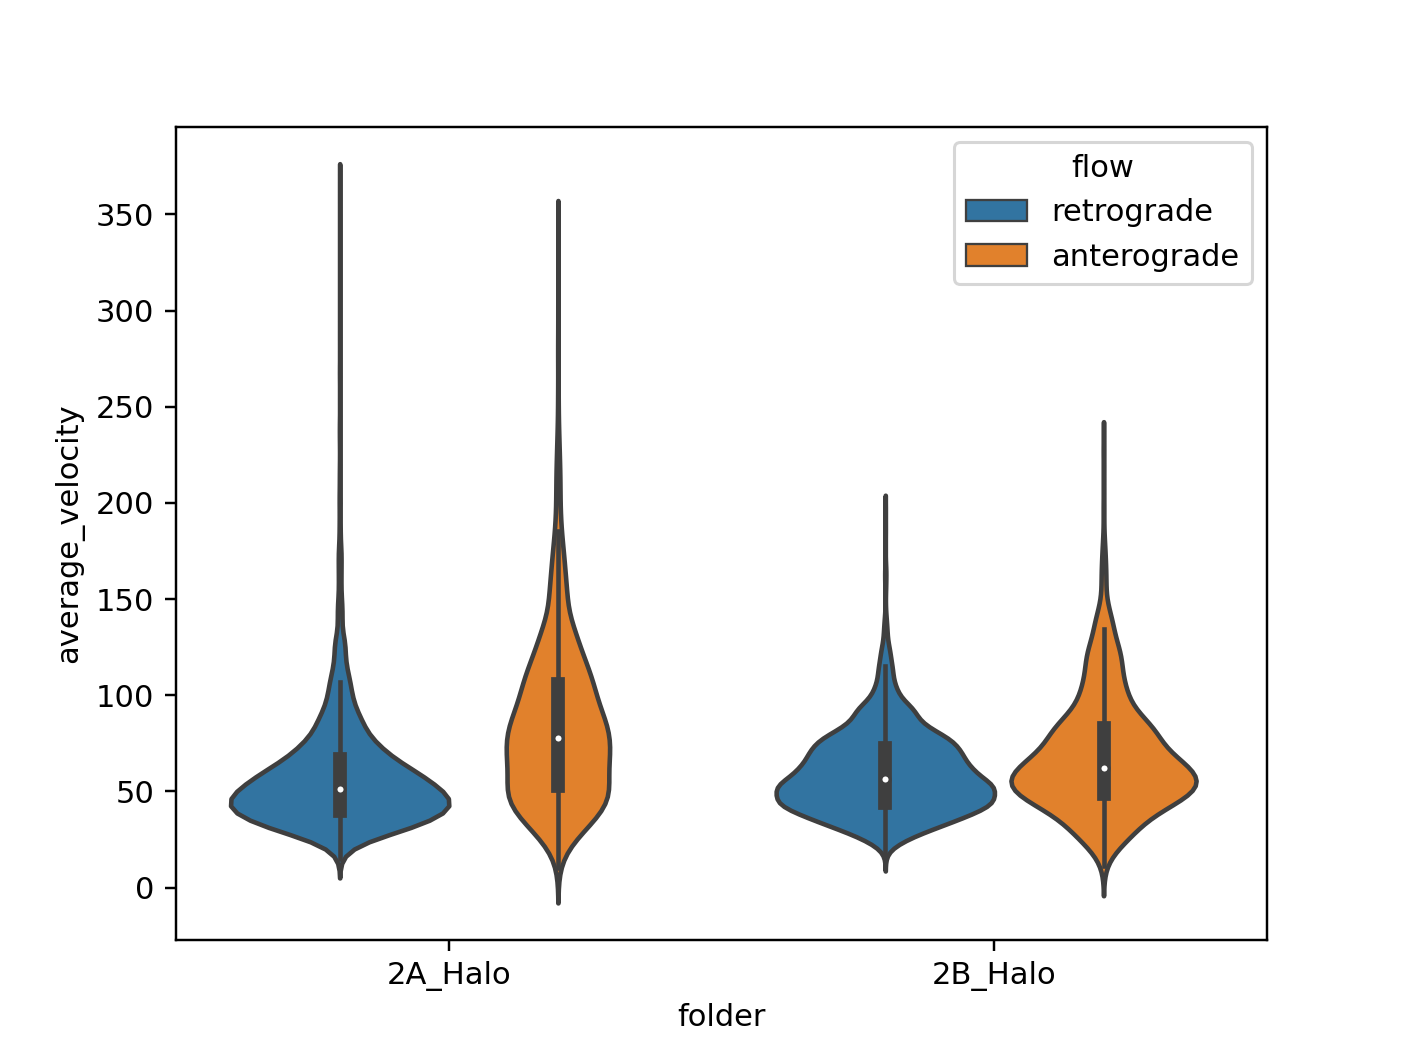

In [15]:
plt.figure()
sns.violinplot(data = all_data, x = 'folder', y='average_velocity', hue='flow')
# sns.swarmplot(data = all_data, x = 'folder', y='average_velocity', hue='flow', dodge=True, palette='dark:k',alpha= 0.5, size = 1)
plt.show()  

In [6]:
plt.savefig('2A_vs_2B_Joey_data.png', dpi=300)
plt.savefig('2A_vs_2B_Joey_data.eps')

/Users/poakes/opt/anaconda3/envs/tfm/lib/python3.11/site-packages/seaborn/categorical.py:3543: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/poakes/opt/anaconda3/envs/tfm/lib/python3.11/site-packages/seaborn/categorical.py:3543: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [7]:
all_2b = all_data[all_data['folder'] == '2B_Halo']
all_2a = all_data[all_data['folder'] == '2A_Halo']
retro_2b = all_2b[all_2b['flow'] == 'retrograde']
antero_2b = all_2b[all_2b['flow'] == 'anterograde']
retro_2a = all_2a[all_2a['flow'] == 'retrograde']
antero_2a = all_2a[all_2a['flow'] == 'anterograde']

In [8]:
print('Retro 2A  : # ', len(retro_2a), ' mean : ' , np.mean(retro_2a['average_velocity']) , ' +/- ', np.std(retro_2a['average_velocity']))
print('Antero 2A : # ', len(antero_2a), ' mean : ' , np.mean(antero_2a['average_velocity']) , ' +/- ', np.std(antero_2a['average_velocity']))
print('Retro 2B  : # ', len(retro_2b), ' mean : ' , np.mean(retro_2b['average_velocity']) , ' +/- ', np.std(retro_2b['average_velocity']))
print('Antero 2B : # ', len(antero_2b), ' mean : ' , np.mean(antero_2b['average_velocity']) , ' +/- ', np.std(antero_2b['average_velocity']))

Retro 2A  : #  5296  mean :  57.52168830494228  +/-  27.478443808118286
Antero 2A : #  1826  mean :  83.9345652696244  +/-  41.064428550063084
Retro 2B  : #  4436  mean :  59.81755374060917  +/-  21.278923610132694
Antero 2B : #  888  mean :  68.60854716192065  +/-  29.59368231420136


<IPython.core.display.Javascript object>


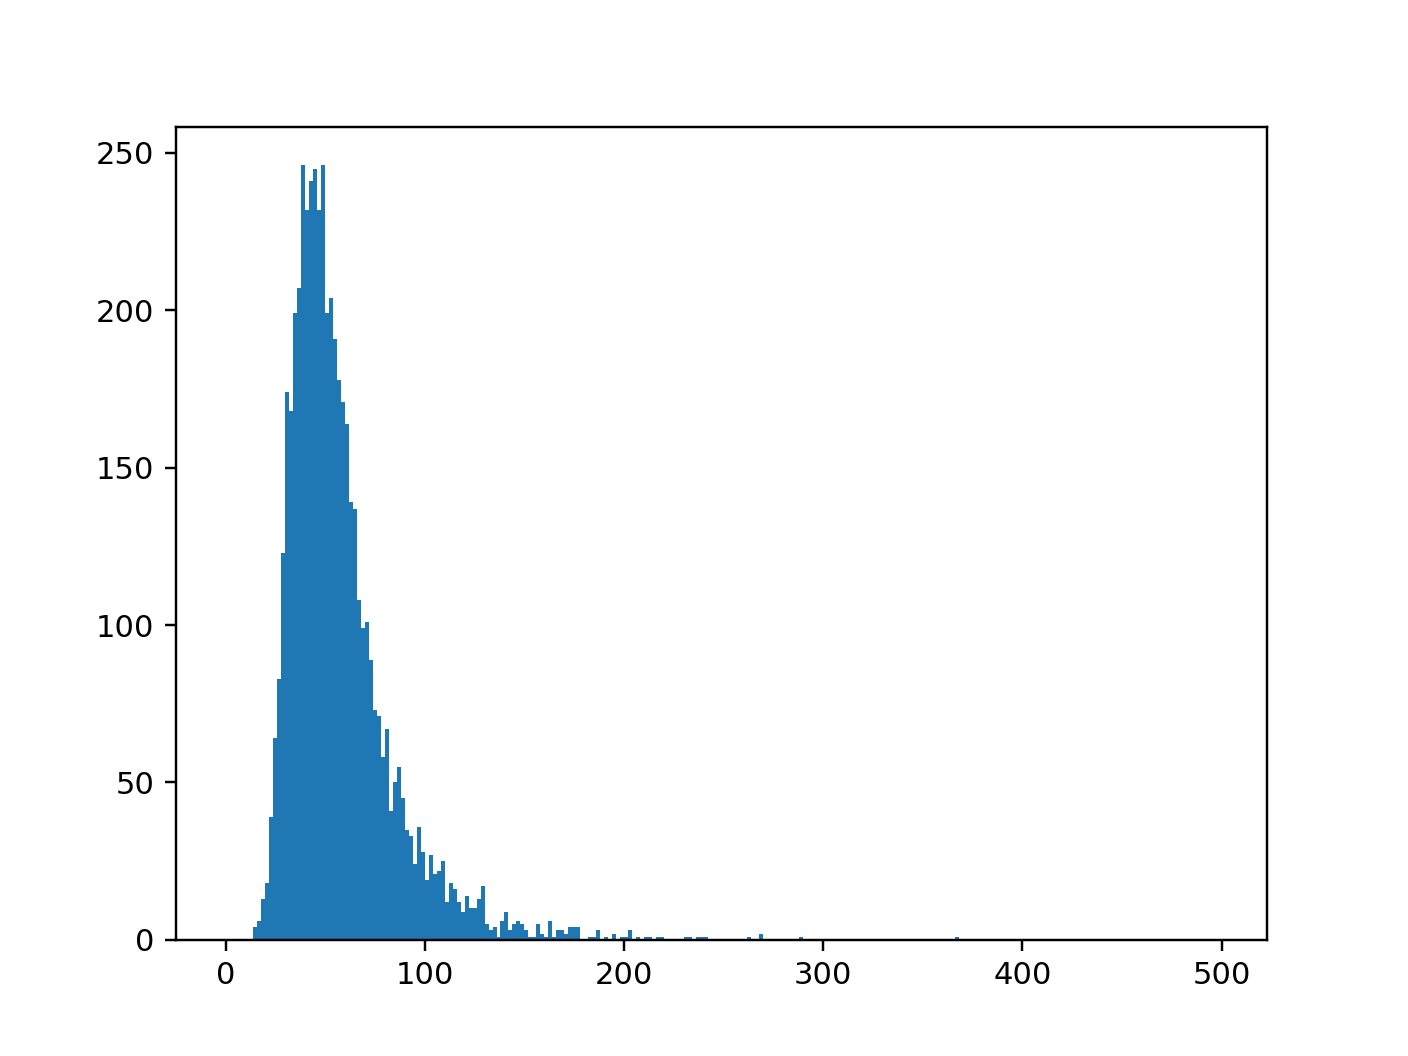

NameError: name 'bins' is not defined

In [9]:
hist_bins = np.arange(0,500,2)
data_2a_retro = retro_2a['average_velocity'].values
# print(data_2a_retro[:100])
plt.figure()
plt.hist(retro_2a['average_velocity'], bins=hist_bins)
plt.plot(bins[:-1],myosin_fit,'r')
plt.xlim(0,200)
plt.show()
print('Center of Gaussian Fit is at : ', params[1])

In [ ]:
from scipy import optimize               # for curve fitting

# We define our function using the intensity counts and the three initial parameters
def gaussian_fit(intensity, A, B, C):
    return A * np.exp(-1 * ((intensity - B) / C) ** 2)

In [ ]:
counts, bins = np.histogram(retro_2a['actual_velocity_smoothed'], bins=bins)


# parameter guesses
# A is going to be related to the maximum of the curve
# B is going to be related to where that maximum is
# C is going to be related to the width of that curve
hist_max = np.argwhere(counts == np.max(counts))
p0 = [np.max(counts), hist_max[0,0], 20]

# Fit the curve
params, params_covariance = optimize.curve_fit(gaussian_fit, bins[:-1], counts, p0)

# Create a fit line using the parameters from your fit and the original bins
myosin_fit = gaussian_fit(bins, params[0], params[1], params[2])

In [ ]:
plt.figure()
sns.kdeplot(
   data=all_2a, x="actual_velocity_smoothed", hue="flow",
   fill=True, common_norm=False, 
   alpha=.75, linewidth=0,
)
plt.title('2A')
plt.xlim(0,300)
plt.show()

plt.figure()
sns.kdeplot(
   data=all_2b, x="actual_velocity_smoothed", hue="flow",
   fill=True, common_norm=False,
   alpha=.75, linewidth=0,
)
plt.title('2B')
plt.xlim(0,300)
plt.show()

In [ ]:
all_data = pd.read_hdf('myosin_2A_and_2B_all_data_combined.h5', key='myosin')

In [13]:
corrected_actual_velocity_smoothed = []
for i, row in all_data.iterrows():
    if row['flow'] == 'retrograde':
        corrected_actual_velocity_smoothed.append(row['average_velocity'] * -1)
    elif row['flow'] == 'anterograde':
        corrected_actual_velocity_smoothed.append(row['average_velocity'])
    else:
        corrected_actual_velocity_smoothed.append(0)

all_data['signed_average_velocity'] = corrected_actual_velocity_smoothed

In [ ]:
all_data.head(1)

<IPython.core.display.Javascript object>


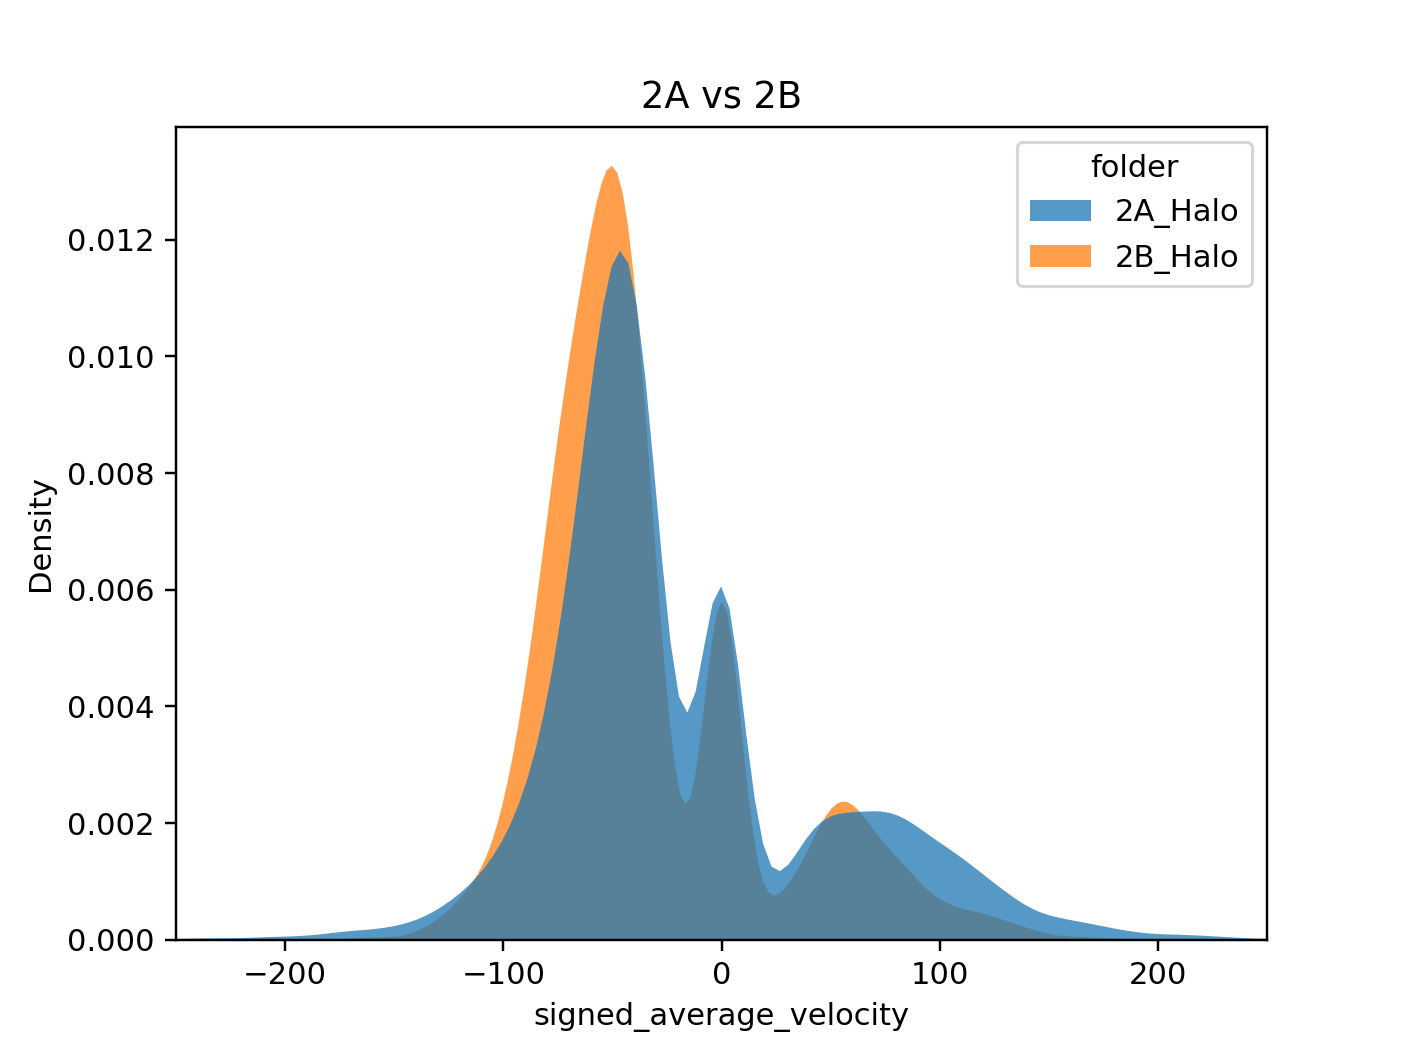

In [14]:
plt.figure()
sns.kdeplot(
   data=all_data, x="signed_average_velocity", hue="folder",
   fill=True, common_norm=False, 
   alpha=.75, linewidth=0,
)
plt.title('2A vs 2B')
plt.xlim(-250,250)
plt.show()

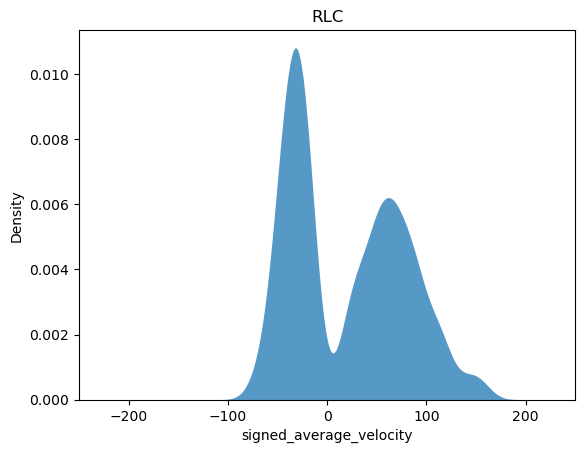

In [15]:
plt.figure()
sns.kdeplot(
   data=all_RLC_data, x="signed_average_velocity",
   fill=True, common_norm=False, 
   alpha=.75, linewidth=0,
)
plt.title('RLC')
plt.xlim(-250,250)
plt.show()

